In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

In [6]:
!pip install utilsforecast
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.3 MB/s eta 0:00:00


In [98]:
df = pd.read_csv("/content/nepsealpha_export_price_NTC_2020-12-21_2025-12-21_unadjusted.csv", encoding="latin1")
df.head()

Symbol        Date   Open   High    Low  Close Percent Change     Volume  \
0    NTC  2025-12-18  889.8  889.8  877.2  878.7        -0.94 %  11,553.00   
1    NTC  2025-12-17  880.1  892.0  880.1  887.0         0.23 %  14,222.00   
2    NTC  2025-12-16  874.0  885.0  872.1  885.0         1.26 %  19,850.00   
3    NTC  2025-12-15  872.5  876.0  872.5  874.0         0.17 %  12,155.00   
4    NTC  2025-12-14  877.0  877.0  865.0  872.5         0.29 %  18,545.00   

       Turn Over  
0  10,192,184.40  
1  12,631,812.70  
2  17,503,179.30  
3  10,631,012.50  
4  16,194,027.10

In [99]:
df['Date'] = pd.to_datetime(df['Date'])

In [100]:
# df.drop("Percent Change",axis=1,inplace=True)
# df.drop("Volume",axis=1,inplace=True)
df.drop("Symbol",axis=1,inplace=True)
df.drop("Turn Over",axis=1,inplace=True)

In [101]:
df['Percent Change'] = df['Percent Change'].str.replace('%', '').astype(float) / 100
df['price_change'] = df['Percent Change'] * df['Close']

In [104]:
df['price_change'] = df['price_change'].round(1)
df.drop("Percent Change",axis=1,inplace=True)

In [105]:
df.head()

Date   Open   High    Low  Close     Volume  price_change
0 2025-12-18  889.8  889.8  877.2  878.7  11,553.00          -8.3
1 2025-12-17  880.1  892.0  880.1  887.0  14,222.00           2.0
2 2025-12-16  874.0  885.0  872.1  885.0  19,850.00          11.2
3 2025-12-15  872.5  876.0  872.5  874.0  12,155.00           1.5
4 2025-12-14  877.0  877.0  865.0  872.5  18,545.00           2.5

In [106]:
df['Volume'] = df['Volume'].astype(str).str.replace(',', '', regex=False)
df['Volume'] = df['Volume'].replace('-', 0) # Replace hyphens with NaN
df['Volume'] = pd.to_numeric(df['Volume'])

In [107]:
df

Date    Open    High     Low   Close   Volume  price_change
0    2025-12-18   889.8   889.8   877.2   878.7  11553.0          -8.3
1    2025-12-17   880.1   892.0   880.1   887.0  14222.0           2.0
2    2025-12-16   874.0   885.0   872.1   885.0  19850.0          11.2
3    2025-12-15   872.5   876.0   872.5   874.0  12155.0           1.5
4    2025-12-14   877.0   877.0   865.0   872.5  18545.0           2.5
...         ...     ...     ...     ...     ...      ...           ...
1162 2020-12-27  1133.0  1133.0  1079.0  1083.0      0.0          -0.3
1163 2020-12-24  1150.0  1150.0  1099.0  1111.0      0.0          -0.3
1164 2020-12-23  1200.0  1210.0  1140.0  1150.0      0.0          -0.2
1165 2020-12-22  1108.0  1170.0  1088.0  1169.0      0.0           0.9
1166 2020-12-21  1029.0  1105.0  1000.0  1087.0      0.0           0.4

[1167 rows x 7 columns]

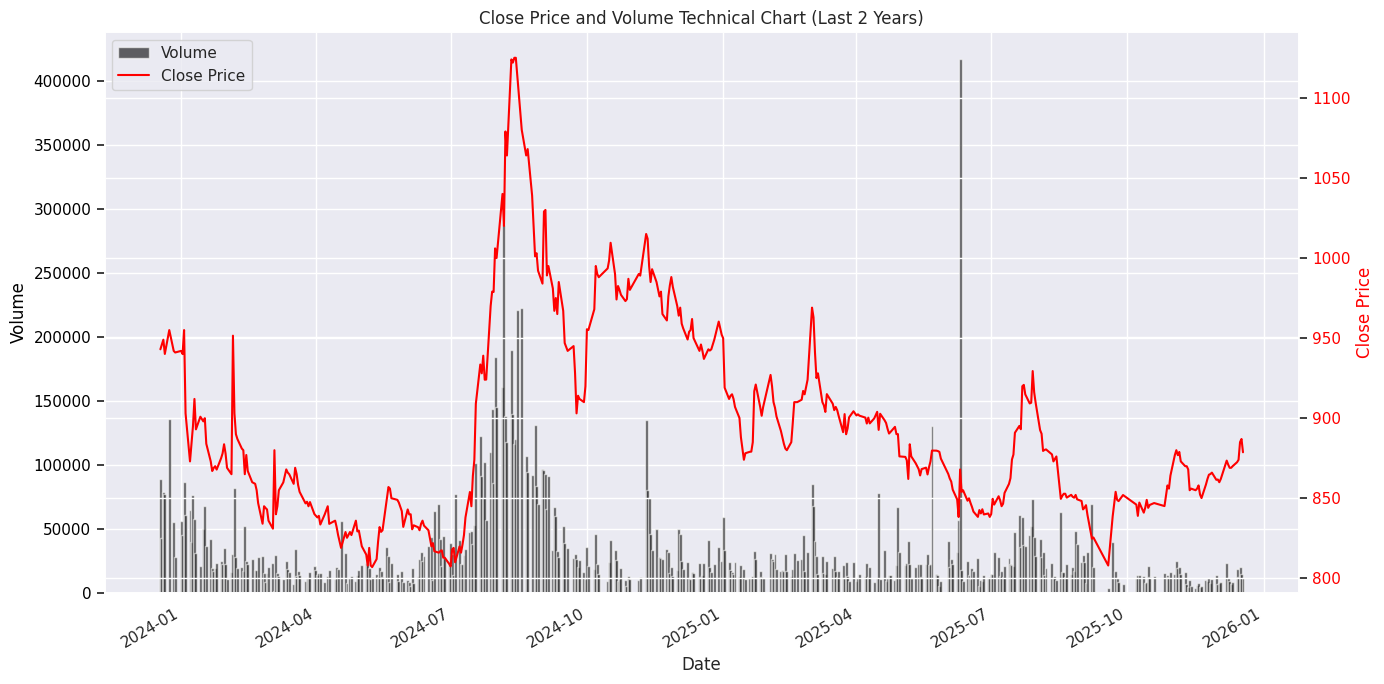

In [133]:
import matplotlib.pyplot as plt

# Ensure the DataFrame is sorted by Date
df_sorted = df.sort_values(by='Date').copy()

# Filter for the last 2 years of data
end_date = df_sorted['Date'].max()
start_date = end_date - pd.DateOffset(years=2)
df_filtered = df_sorted[(df_sorted['Date'] >= start_date) & (df_sorted['Date'] <= end_date)]

# Create figure and primary axes for Volume
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Volume as a bar chart on ax1
ax1.bar(df_filtered['Date'], df_filtered['Volume'], color='black', alpha=0.6, label='Volume', width=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Volume', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for Close price
ax2 = ax1.twinx()

# Plot Close price as a line chart on ax2
ax2.plot(df_filtered['Date'], df_filtered['Close'], color='red', label='Close Price')
ax2.set_ylabel('Close Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set chart title and legends
plt.title('Close Price and Volume Technical Chart (Last 2 Years)')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Rotate x-axis labels for better readability
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

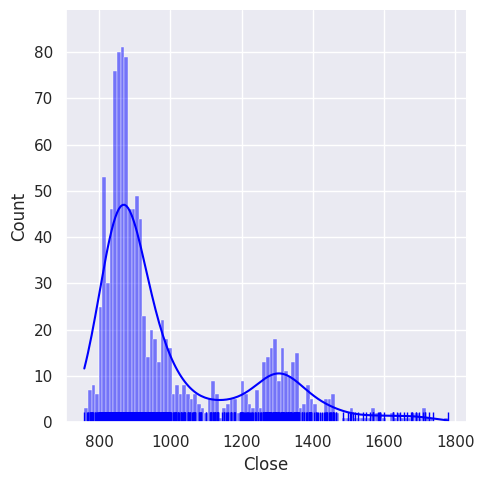

In [127]:
sns.set(style='darkgrid')
sns.displot(df['Close'],rug=True,color='blue',kde=True,bins=100);

In [108]:
df_long = df.melt(
    id_vars=["Date"],
    value_vars=["Open", "High", "Low", "Close","Volume","price_change"],
    var_name="unique_id",
    value_name="y"
).rename(columns={"Date": "ds"})

In [109]:
df_long.head()

ds unique_id      y
0 2025-12-18      Open  889.8
1 2025-12-17      Open  880.1
2 2025-12-16      Open  874.0
3 2025-12-15      Open  872.5
4 2025-12-14      Open  877.0

In [110]:
df_long = (
    df_long
    .groupby(['ds', 'unique_id'], as_index=False)['y']
    .mean()
)


In [111]:
df_long

ds     unique_id        y
0    2020-12-21         Close   1087.0
1    2020-12-21          High   1105.0
2    2020-12-21           Low   1000.0
3    2020-12-21          Open   1029.0
4    2020-12-21        Volume      0.0
...         ...           ...      ...
6997 2025-12-18          High    889.8
6998 2025-12-18           Low    877.2
6999 2025-12-18          Open    889.8
7000 2025-12-18        Volume  11553.0
7001 2025-12-18  price_change     -8.3

[7002 rows x 3 columns]

In [70]:
df_long.info

<bound method DataFrame.info of              ds unique_id        y
0    2020-12-21     Close   1087.0
1    2020-12-21      High   1105.0
2    2020-12-21       Low   1000.0
3    2020-12-21      Open   1029.0
4    2020-12-21    Volume      0.0
...         ...       ...      ...
5830 2025-12-18     Close    878.7
5831 2025-12-18      High    889.8
5832 2025-12-18       Low    877.2
5833 2025-12-18      Open    889.8
5834 2025-12-18    Volume  11553.0

[5835 rows x 3 columns]>

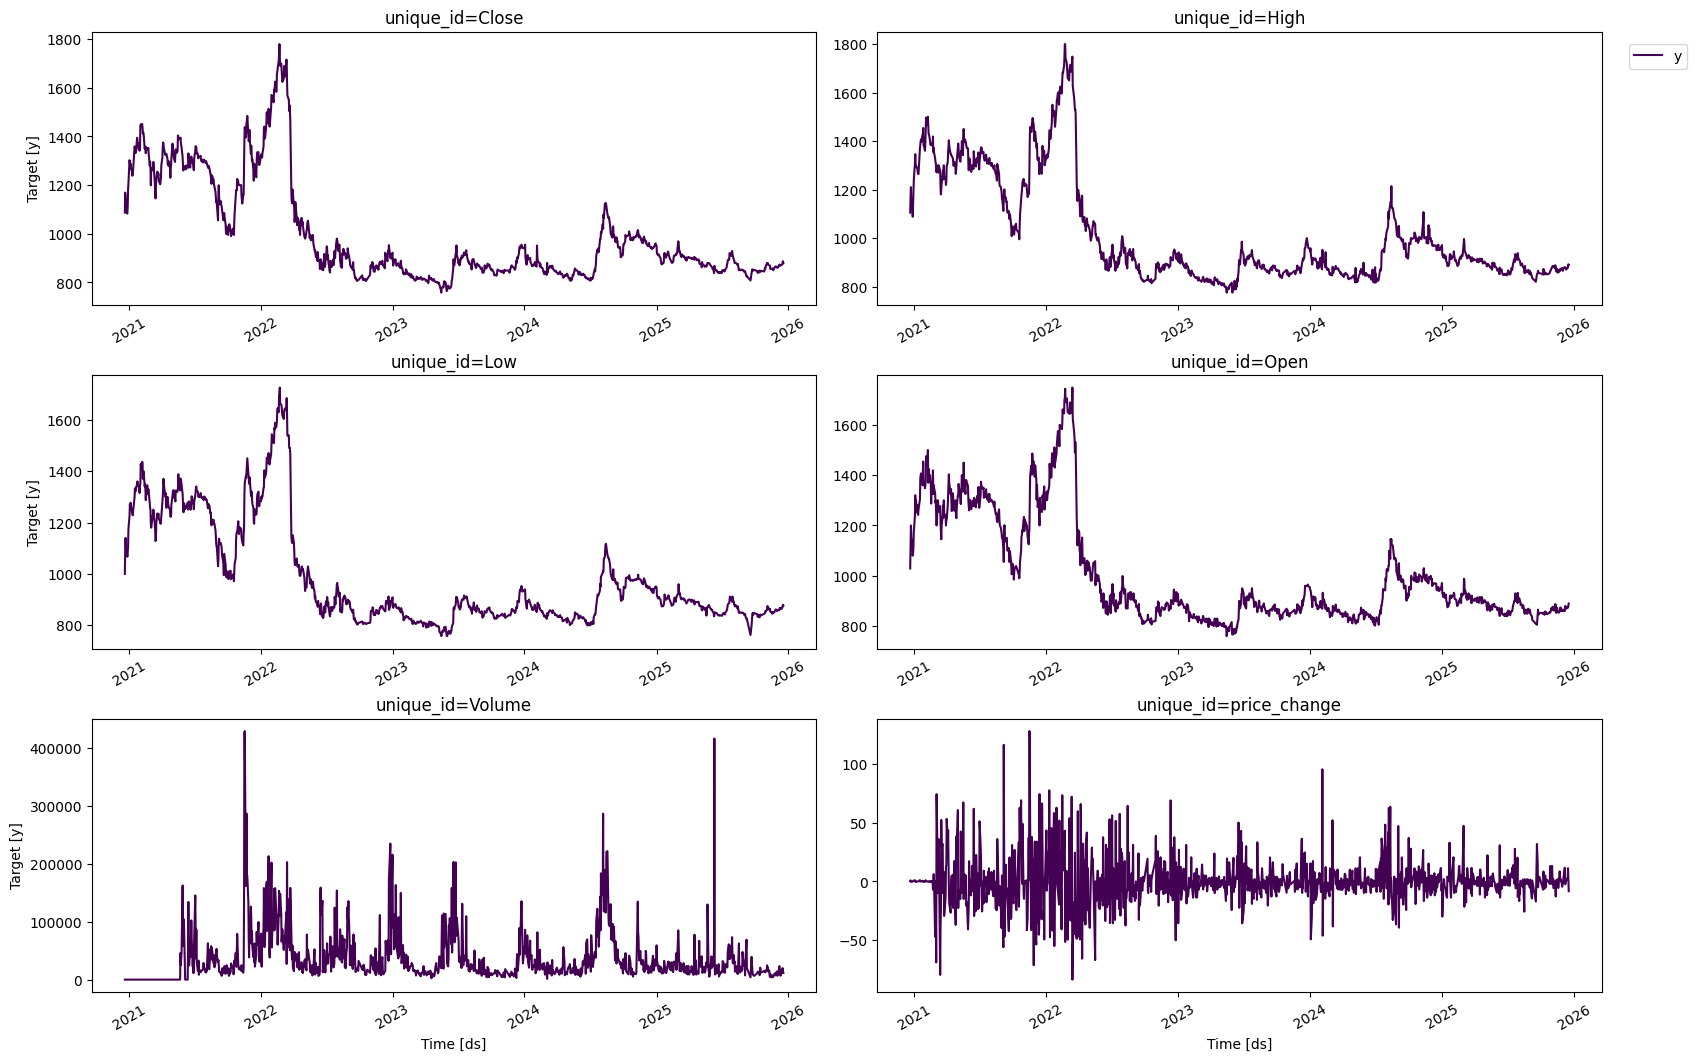

In [112]:
plot_series(df=df_long, palette="viridis")

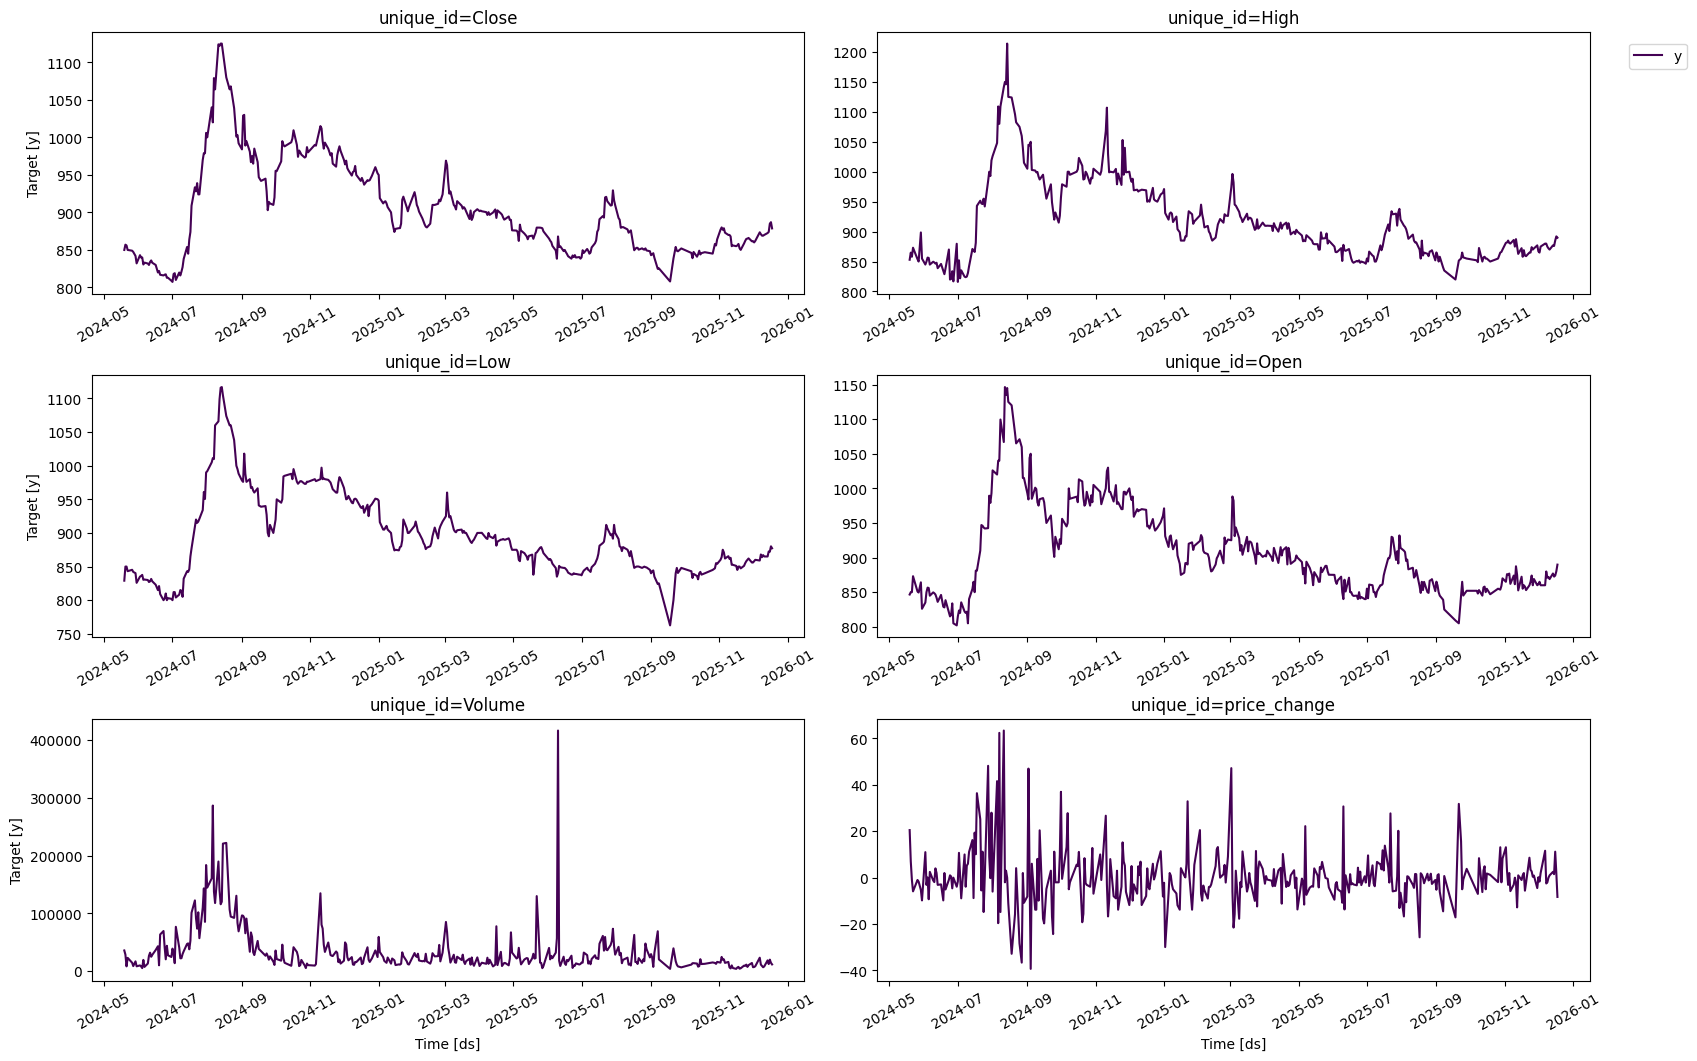

In [113]:
plot_series(df=df_long, max_insample_length=30*12, palette="viridis")

Time Series Decomposition

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

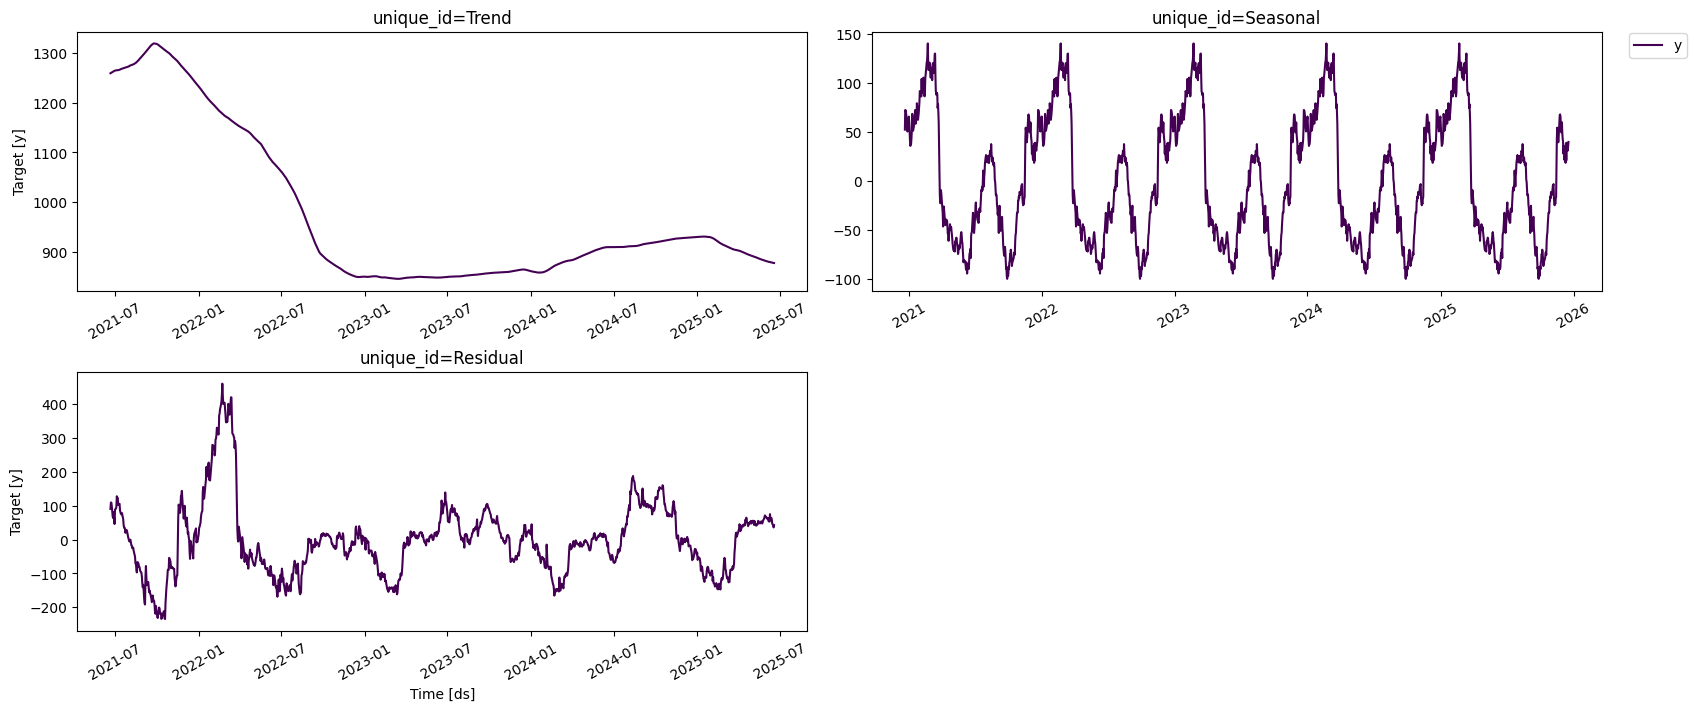

In [114]:
var = "Close"
ts = (
    df_long[df_long["unique_id"] == var]
    .set_index("ds")["y"]
    .asfreq("D") # Changed from "h" to "D" for daily data
    .interpolate(method="linear") # Interpolate missing values
)

result = seasonal_decompose(ts, model="additive", period=365) # Changed period to 7 for weekly seasonality

components_long = pd.concat([
    result.trend.rename("Trend"),
    result.seasonal.rename("Seasonal"),
    result.resid.rename("Residual")
], axis=1).reset_index().melt(id_vars="ds", var_name="unique_id", value_name="y")

plot_series(
    df=pd.DataFrame({"ds": ts.index, "unique_id": var, "y": ts.values}),
    max_insample_length=365, # Adjusted for daily data plotting length
    forecasts_df=components_long,
    ids=["Trend", "Seasonal", "Residual"],
    palette="viridis"
)

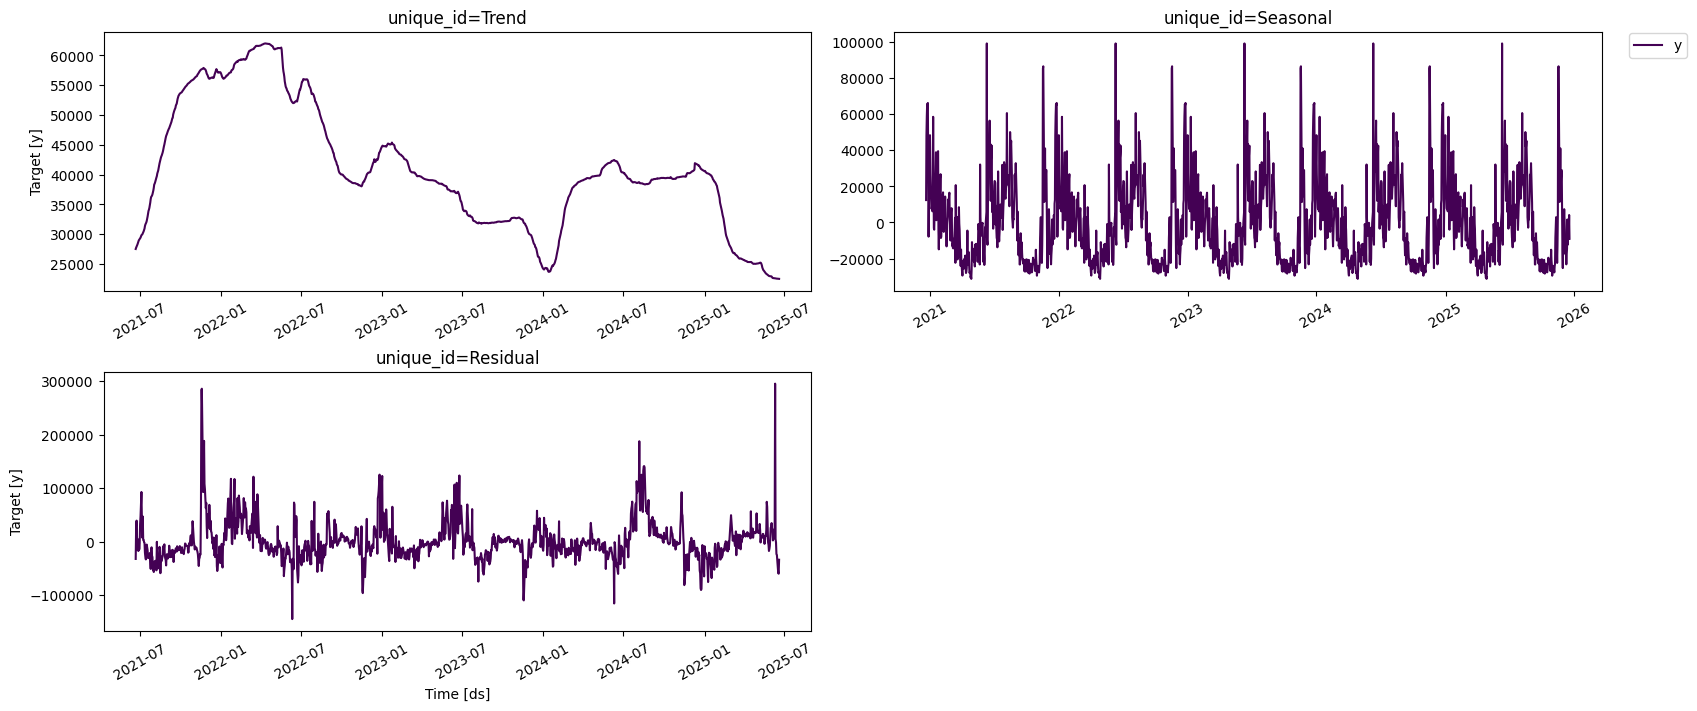

In [81]:
var = "Volume"
ts = (
    df_long[df_long["unique_id"] == var]
    .set_index("ds")["y"]
    .asfreq("D")
    .interpolate(method="linear")
)

result = seasonal_decompose(ts, model="additive", period=365)

components_long = pd.concat([
    result.trend.rename("Trend"),
    result.seasonal.rename("Seasonal"),
    result.resid.rename("Residual")
], axis=1).reset_index().melt(id_vars="ds", var_name="unique_id", value_name="y")

plot_series(
    df=pd.DataFrame({"ds": ts.index, "unique_id": var, "y": ts.values}),
    max_insample_length=365,
    forecasts_df=components_long,
    ids=["Trend", "Seasonal", "Residual"],
    palette="viridis"
)

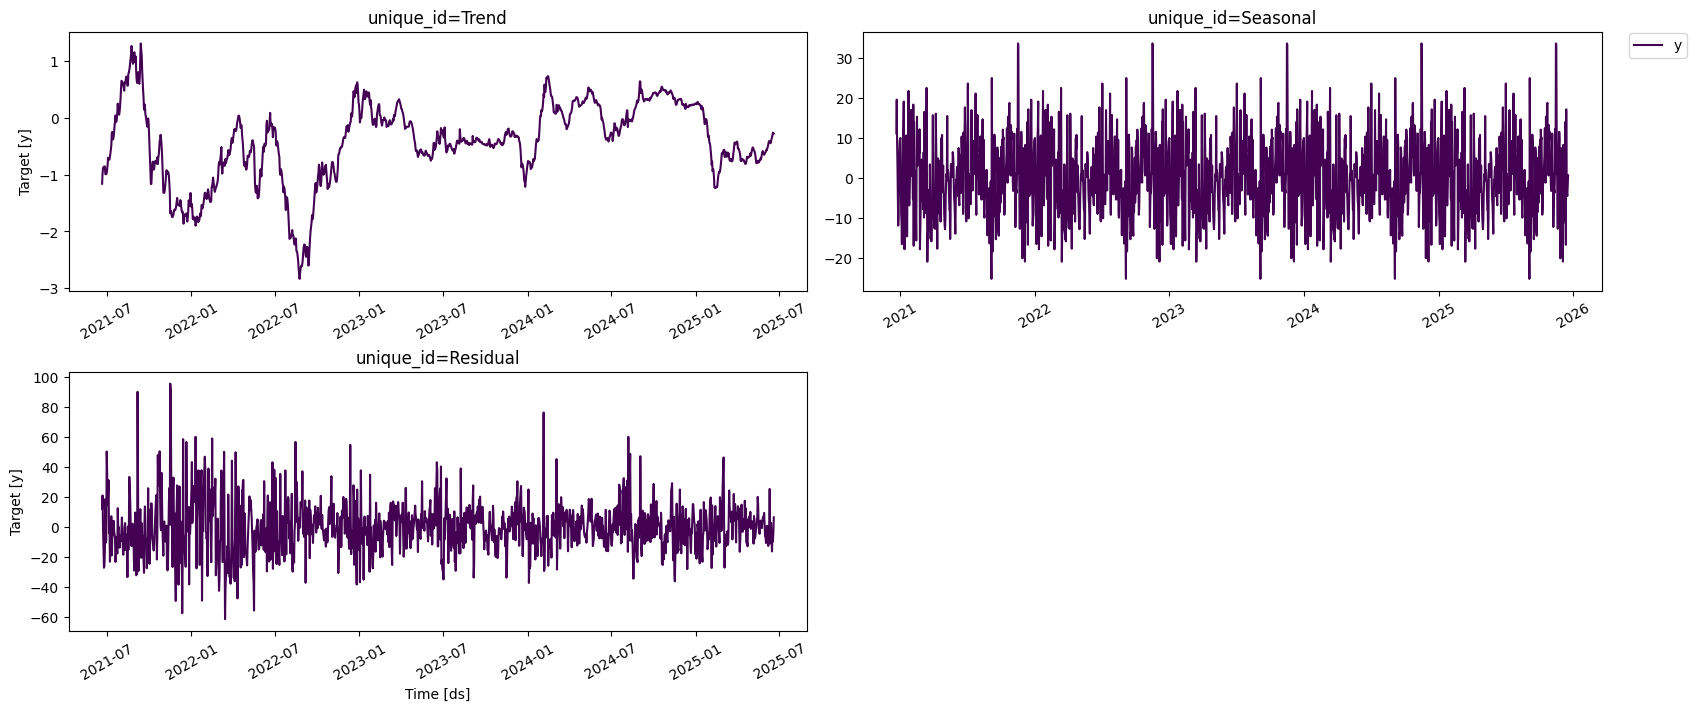

In [115]:
var = "price_change"
ts = (
    df_long[df_long["unique_id"] == var]
    .set_index("ds")["y"]
    .asfreq("D") # Changed from "h" to "D" for daily data
    .interpolate(method="linear") # Interpolate missing values
)

result = seasonal_decompose(ts, model="additive", period=365) # Changed period to 7 for weekly seasonality

components_long = pd.concat([
    result.trend.rename("Trend"),
    result.seasonal.rename("Seasonal"),
    result.resid.rename("Residual")
], axis=1).reset_index().melt(id_vars="ds", var_name="unique_id", value_name="y")

plot_series(
    df=pd.DataFrame({"ds": ts.index, "unique_id": var, "y": ts.values}),
    max_insample_length=365, # Adjusted for daily data plotting length
    forecasts_df=components_long,
    ids=["Trend", "Seasonal", "Residual"],
    palette="viridis"
)

Baseline models

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive
from utilsforecast.losses import *


d:\Projects\weather_windows\WeatherStation\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [ ]:
horizon = 24
season_length = 24

In [ ]:
test = df_long.groupby("unique_id").tail(24)
train = df_long.drop(test.index).reset_index(drop=True)

In [ ]:
models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=24),
    SeasonalNaive(season_length=season_length)
]

sf = StatsForecast(models=models, freq="h")
sf.fit(df=train)
preds = sf.predict(h=horizon)

In [ ]:
preds.head()

unique_id                  ds  Naive  HistoricAverage  \
0  atmospheric_pressure 2025-08-04 00:00:00  867.3       867.658735   
1  atmospheric_pressure 2025-08-04 01:00:00  867.3       867.658735   
2  atmospheric_pressure 2025-08-04 02:00:00  867.3       867.658735   
3  atmospheric_pressure 2025-08-04 03:00:00  867.3       867.658735   
4  atmospheric_pressure 2025-08-04 04:00:00  867.3       867.658735   

   WindowAverage  SeasonalNaive  
0       865.9375          865.6  
1       865.9375          864.3  
2       865.9375          863.7  
3       865.9375          863.5  
4       865.9375          864.1

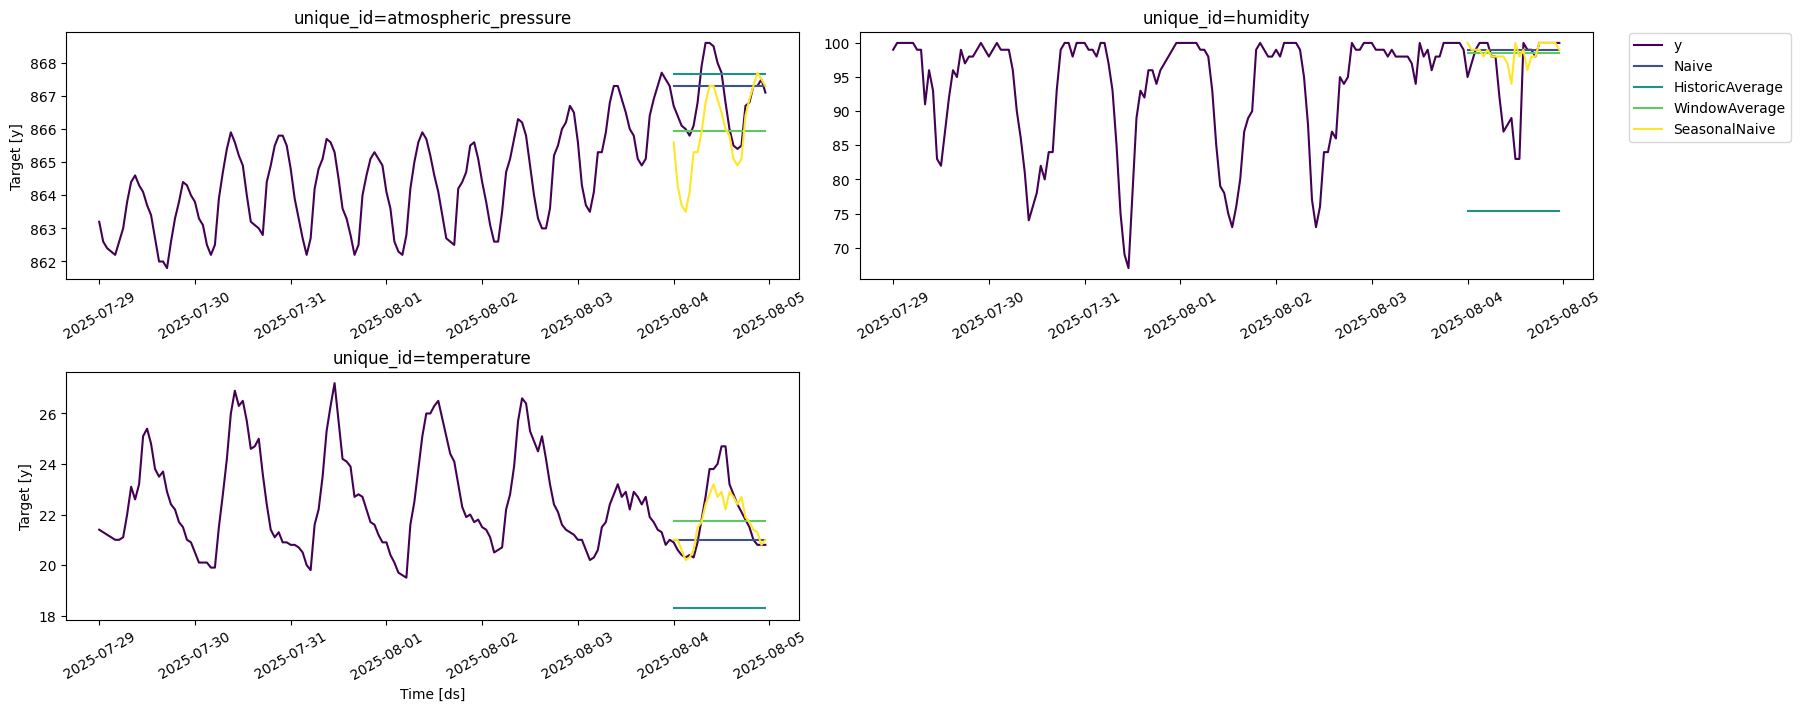

In [ ]:
plot_series(
    df=df_long,
    forecasts_df=preds,
    max_insample_length=24*7,
    palette="viridis")

Evaluate Baseline Models

In [ ]:
# test = df_long.groupby("unique_id").tail(24)
# train = df_long.drop(test.index).reset_index(drop=True)

In [ ]:
test

ds             unique_id      y
41832 2025-08-04 00:00:00  atmospheric_pressure  866.7
41833 2025-08-04 00:00:00              humidity   95.0
41834 2025-08-04 00:00:00           temperature   20.9
41835 2025-08-04 01:00:00  atmospheric_pressure  866.4
41836 2025-08-04 01:00:00              humidity   97.0
...                   ...                   ...    ...
41899 2025-08-04 22:00:00              humidity  100.0
41900 2025-08-04 22:00:00           temperature   20.8
41901 2025-08-04 23:00:00  atmospheric_pressure  867.1
41902 2025-08-04 23:00:00              humidity  100.0
41903 2025-08-04 23:00:00           temperature   20.8

[72 rows x 3 columns]

In [ ]:
train

ds             unique_id      y
0     2024-01-01 00:00:00  atmospheric_pressure  868.0
1     2024-01-01 00:00:00              humidity   93.0
2     2024-01-01 00:00:00           temperature    7.2
3     2024-01-01 01:00:00  atmospheric_pressure  867.8
4     2024-01-01 01:00:00              humidity   92.0
...                   ...                   ...    ...
41827 2025-08-03 22:00:00              humidity  100.0
41828 2025-08-03 22:00:00           temperature   20.8
41829 2025-08-03 23:00:00  atmospheric_pressure  867.3
41830 2025-08-03 23:00:00              humidity   99.0
41831 2025-08-03 23:00:00           temperature   21.0

[41832 rows x 3 columns]

In [ ]:
sf.fit(df=train)

preds = sf.predict(h=horizon)

eval_df = pd.merge(test, preds, 'left', ['ds', 'unique_id'])

In [ ]:
preds.head()

unique_id                  ds  Naive  HistoricAverage  \
0  atmospheric_pressure 2025-08-04 00:00:00  867.3       867.658735   
1  atmospheric_pressure 2025-08-04 01:00:00  867.3       867.658735   
2  atmospheric_pressure 2025-08-04 02:00:00  867.3       867.658735   
3  atmospheric_pressure 2025-08-04 03:00:00  867.3       867.658735   
4  atmospheric_pressure 2025-08-04 04:00:00  867.3       867.658735   

   WindowAverage  SeasonalNaive  
0       865.9375          865.6  
1       865.9375          864.3  
2       865.9375          863.7  
3       865.9375          863.5  
4       865.9375          864.1

In [ ]:
eval_df.head()

ds             unique_id      y  Naive  HistoricAverage  \
0 2025-08-04 00:00:00  atmospheric_pressure  866.7  867.3       867.658735   
1 2025-08-04 00:00:00              humidity   95.0   99.0        75.342226   
2 2025-08-04 00:00:00           temperature   20.9   21.0        18.287980   
3 2025-08-04 01:00:00  atmospheric_pressure  866.4  867.3       867.658735   
4 2025-08-04 01:00:00              humidity   97.0   99.0        75.342226   

   WindowAverage  SeasonalNaive  
0     865.937500          865.6  
1      98.541667          100.0  
2      21.745833           21.0  
3     865.937500          864.3  
4      98.541667           99.0

In [ ]:
evaluation = evaluate(
    eval_df,
    metrics=[mae],
)
evaluation.head()

unique_id metric     Naive  HistoricAverage  WindowAverage  \
0  atmospheric_pressure    mae  0.895833         1.058534       1.070833   
1              humidity    mae  3.791667        20.699441       3.829861   
2           temperature    mae  1.254167         3.649520       1.212500   

   SeasonalNaive  
0       1.000000  
1       3.333333  
2       0.491667

In [ ]:
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation

metric     Naive  HistoricAverage  WindowAverage  SeasonalNaive
0    mae  1.980556         8.469165       2.037731       1.608333

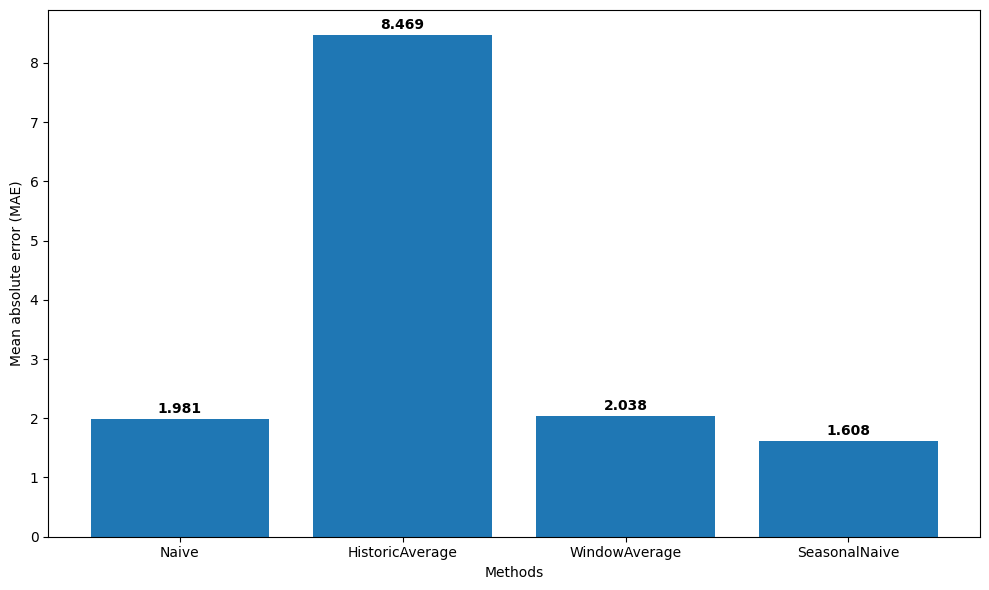

In [ ]:
methods = evaluation.columns[1:].tolist()
values = evaluation.iloc[0, 1:].tolist()

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

AutoARIMA

In [ ]:
from statsforecast.models import AutoARIMA

In [ ]:
unique_ids = ["temperature", "humidity", "atmospheric_pressure"]

In [ ]:
# season_length = 24

In [ ]:
small_train = train[train["unique_id"].isin(unique_ids)].tail(24*15)
small_test = test[test["unique_id"].isin(unique_ids)]

In [ ]:
models = [
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=season_length, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="h", n_jobs=3)
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(arima_preds, eval_df, 'inner', ['ds', 'unique_id'])
arima_eval = evaluate(
    arima_eval_df,
    metrics=[mae],
)
arima_eval

unique_id metric     ARIMA    SARIMA     Naive  HistoricAverage  \
0  atmospheric_pressure    mae  0.476382  0.615746  0.895833         1.058534   
1              humidity    mae  5.799263  3.129353  3.791667        20.699441   
2           temperature    mae  1.126547  0.420576  1.254167         3.649520   

   WindowAverage  SeasonalNaive  
0       1.070833       1.000000  
1       3.829861       3.333333  
2       1.212500       0.491667

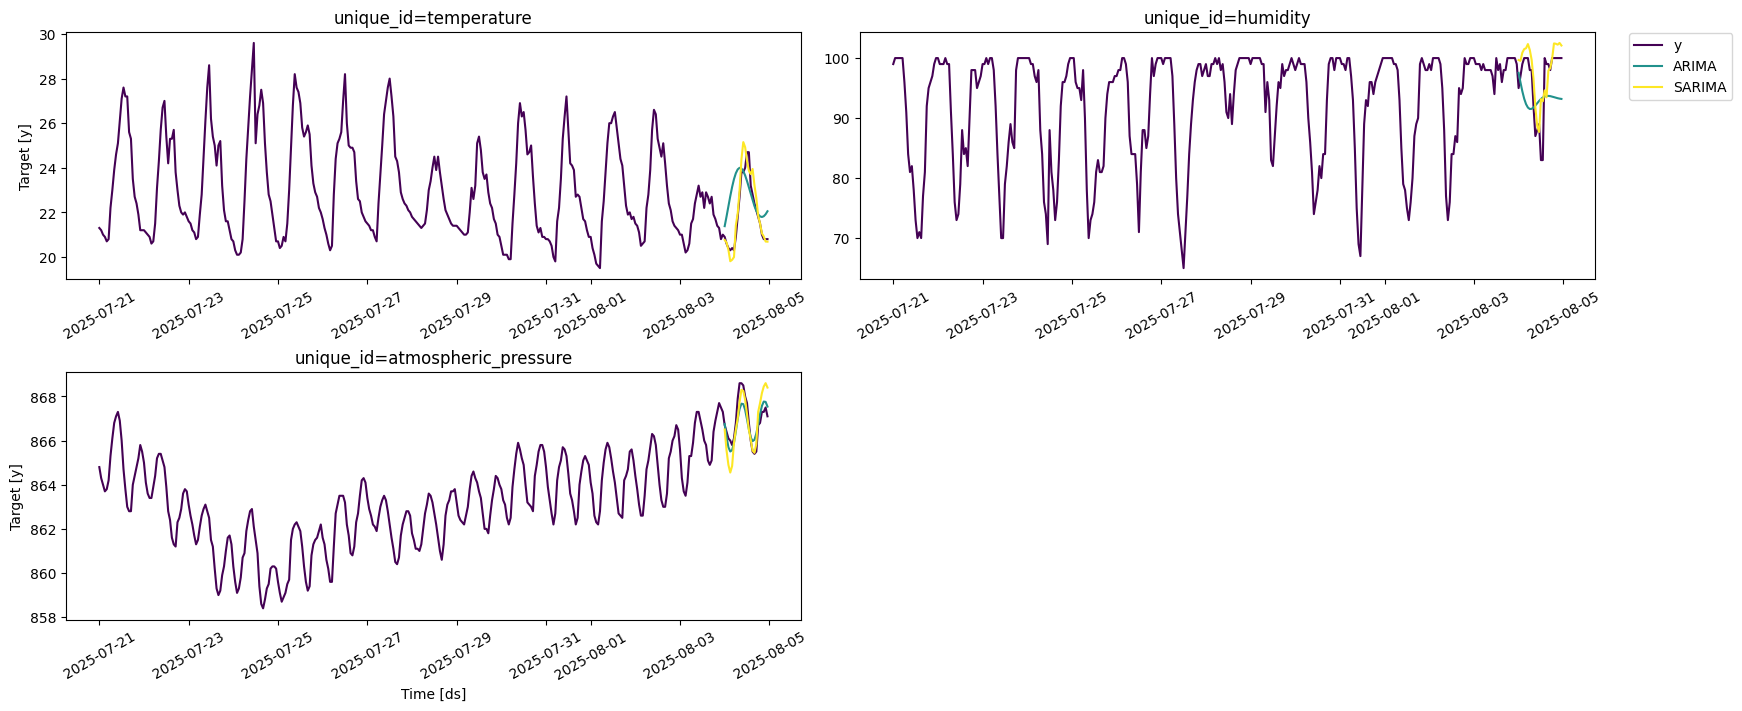

In [ ]:
plot_series(
    df=df_long,
    forecasts_df=arima_preds,
    ids=unique_ids,
    max_insample_length=24*15,
    palette="viridis")

In [ ]:
arima_eval = arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
arima_eval

metric     ARIMA    SARIMA     Naive  HistoricAverage  WindowAverage  \
0    mae  2.467397  1.388558  1.980556         8.469165       2.037731   

   SeasonalNaive  
0       1.608333

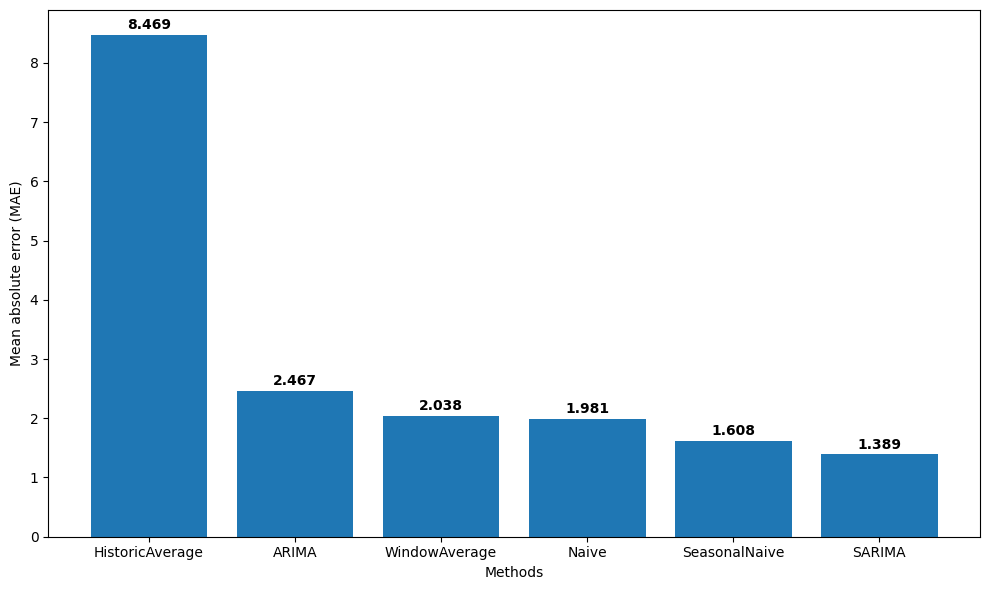

In [ ]:
methods = arima_eval.columns[1:].tolist()
values = arima_eval.iloc[0, 1:].tolist()

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

Cross-vallidation

In [ ]:
small_df = df_long[df_long["unique_id"].isin(unique_ids)].tail(24*30)

In [ ]:
small_df.head()

ds             unique_id      y
41184 2025-07-26 00:00:00  atmospheric_pressure  861.6
41185 2025-07-26 00:00:00              humidity   97.0
41186 2025-07-26 00:00:00           temperature   21.7
41187 2025-07-26 01:00:00  atmospheric_pressure  861.3
41188 2025-07-26 01:00:00              humidity   98.0

In [ ]:
small_df.info

<bound method DataFrame.info of                        ds             unique_id      y
41184 2025-07-26 00:00:00  atmospheric_pressure  861.6
41185 2025-07-26 00:00:00              humidity   97.0
41186 2025-07-26 00:00:00           temperature   21.7
41187 2025-07-26 01:00:00  atmospheric_pressure  861.3
41188 2025-07-26 01:00:00              humidity   98.0
...                   ...                   ...    ...
41899 2025-08-04 22:00:00              humidity  100.0
41900 2025-08-04 22:00:00           temperature   20.8
41901 2025-08-04 23:00:00  atmospheric_pressure  867.1
41902 2025-08-04 23:00:00              humidity  100.0
41903 2025-08-04 23:00:00           temperature   20.8

[720 rows x 3 columns]>

In [ ]:
horizon

24

In [ ]:
season_length

24

In [ ]:
models = [
    SeasonalNaive(season_length=season_length),
]

sf = StatsForecast(models=models, freq="h", n_jobs=3)
sn_cv_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=4,
    step_size=horizon,
    refit=True
)

sn_cv_df.head()

unique_id                  ds              cutoff      y  \
0  atmospheric_pressure 2025-08-01 00:00:00 2025-07-31 23:00:00  864.1   
1  atmospheric_pressure 2025-08-01 01:00:00 2025-07-31 23:00:00  863.6   
2  atmospheric_pressure 2025-08-01 02:00:00 2025-07-31 23:00:00  862.6   
3  atmospheric_pressure 2025-08-01 03:00:00 2025-07-31 23:00:00  862.3   
4  atmospheric_pressure 2025-08-01 04:00:00 2025-07-31 23:00:00  862.2   

   SeasonalNaive  
0          864.8  
1          863.9  
2          863.3  
3          862.7  
4          862.2

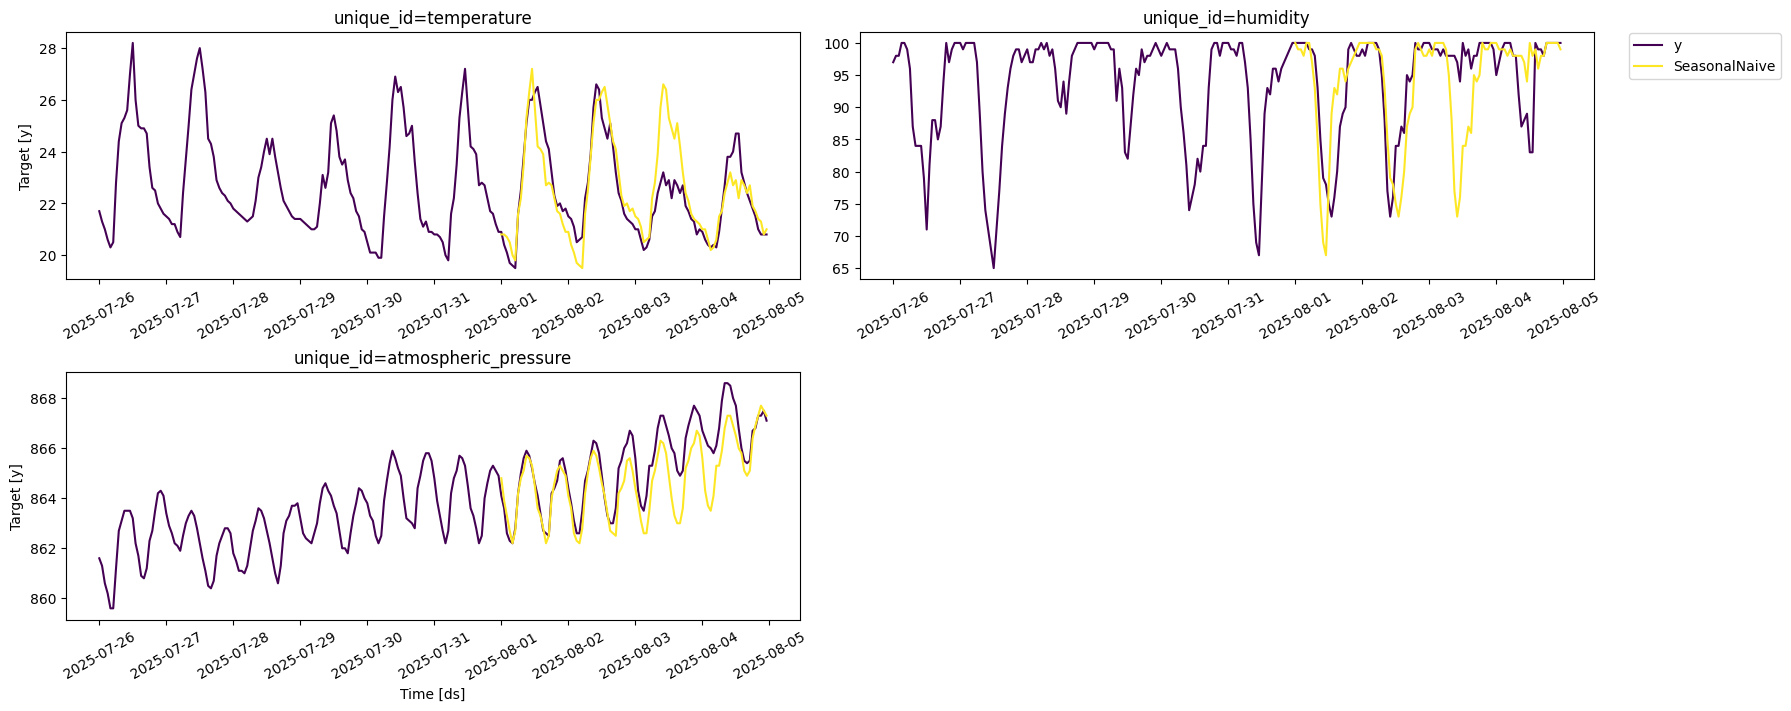

In [ ]:
plot_series(
    df=small_df,
    forecasts_df=sn_cv_df.drop(["y", "cutoff"], axis=1),
    ids=["temperature", "humidity", "atmospheric_pressure"],
    max_insample_length=24*30,
    palette="viridis")

In [ ]:
models = [
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=season_length, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="h", n_jobs=3)
cv_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=4,
    step_size=horizon,
    refit=False
)

cv_df.head()

unique_id                  ds              cutoff      y  \
0  atmospheric_pressure 2025-08-01 00:00:00 2025-07-31 23:00:00  864.1   
1  atmospheric_pressure 2025-08-01 01:00:00 2025-07-31 23:00:00  863.6   
2  atmospheric_pressure 2025-08-01 02:00:00 2025-07-31 23:00:00  862.6   
3  atmospheric_pressure 2025-08-01 03:00:00 2025-07-31 23:00:00  862.3   
4  atmospheric_pressure 2025-08-01 04:00:00 2025-07-31 23:00:00  862.2   

        ARIMA      SARIMA  
0  864.401044  864.375905  
1  863.821631  863.712292  
2  863.408240  863.312335  
3  863.246310  862.850890  
4  863.319415  862.511401

In [ ]:
cv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  288 non-null    object        
 1   ds         288 non-null    datetime64[ns]
 2   cutoff     288 non-null    datetime64[ns]
 3   y          288 non-null    float64       
 4   ARIMA      288 non-null    float64       
 5   SARIMA     288 non-null    float64       
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 13.6+ KB


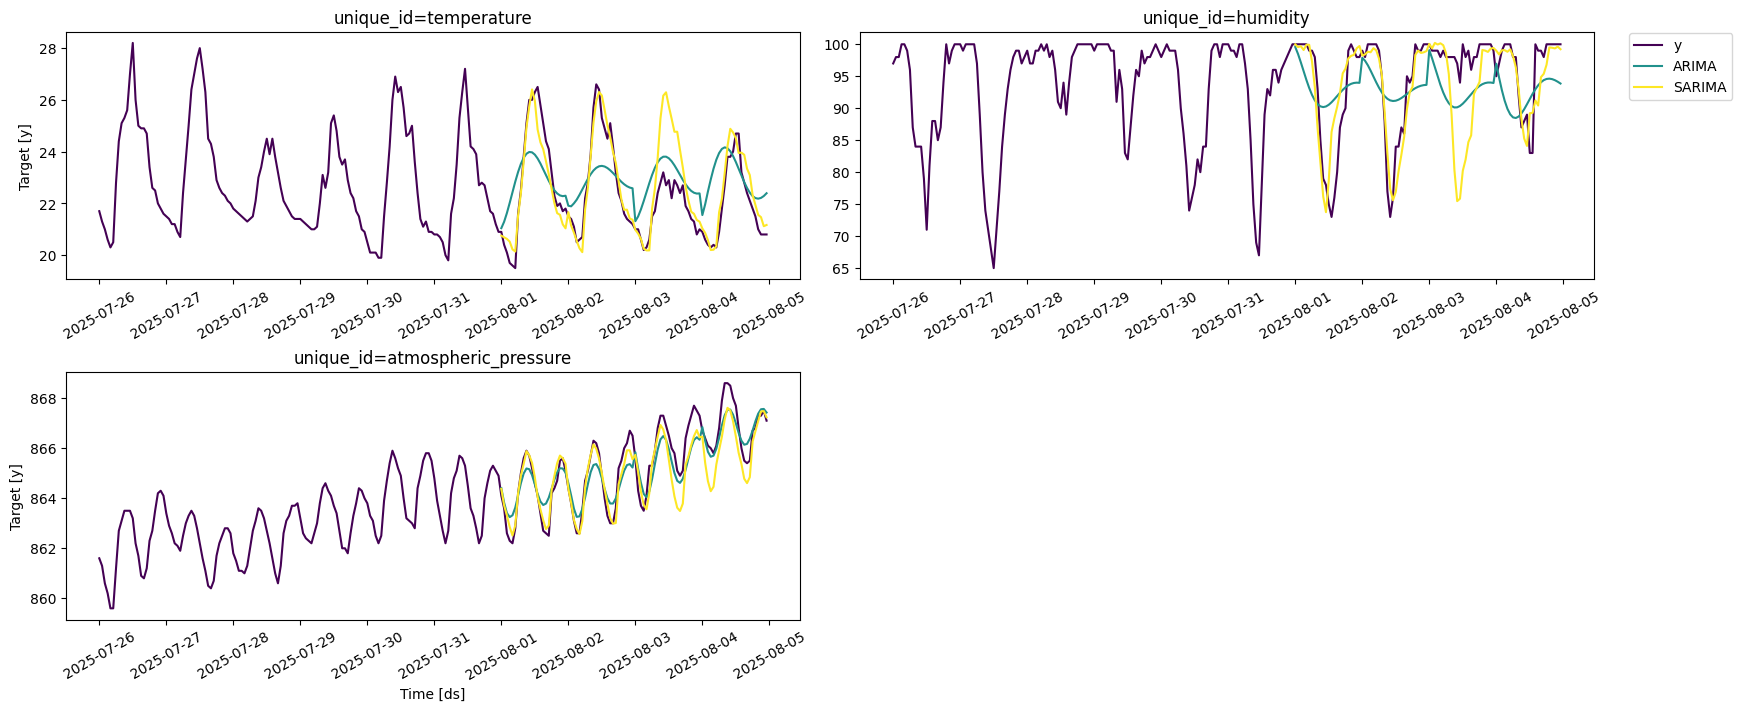

In [ ]:
plot_series(
    df=small_df,
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1),
    ids=["temperature", "humidity", "atmospheric_pressure"],
    max_insample_length=24*30,
    palette="viridis")

In [ ]:
cv_eval = evaluate(
    cv_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
cv_eval

unique_id metric     ARIMA    SARIMA
0  atmospheric_pressure    mae  0.601305  0.543186
1              humidity    mae  6.029089  3.709128
2           temperature    mae  1.263665  0.635553

In [ ]:
sn_cv_eval = evaluate(
    sn_cv_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
sn_cv_eval

unique_id metric  SeasonalNaive
0  atmospheric_pressure    mae       0.776042
1              humidity    mae       4.677083
2           temperature    mae       0.759375

In [ ]:
cv_eval_mean = cv_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_eval_mean

metric     ARIMA    SARIMA
0    mae  2.631353  1.629289

In [ ]:
sn_cv_eval_mean = sn_cv_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
sn_cv_eval_mean

metric  SeasonalNaive
0    mae       2.070833

Forecasting with exogenous features

Creating features from timestamps

In [ ]:
from functools import partial
from utilsforecast.feature_engineering import fourier, time_features, pipeline

In [ ]:
features = [
    partial(fourier, season_length=season_length, k=4),
    partial(time_features, features=["hour","day", "month"])
]

small_exog_df, futr_exog_df = pipeline(
    df=small_df,
    features=features,
    freq="h",
    h=horizon
)

In [ ]:
small_exog_df.head()

ds             unique_id      y   sin1_24   sin2_24  \
41184 2025-07-26 00:00:00  atmospheric_pressure  861.6  0.258819  0.500000   
41185 2025-07-26 00:00:00              humidity   97.0  0.258819  0.500000   
41186 2025-07-26 00:00:00           temperature   21.7  0.258819  0.500000   
41187 2025-07-26 01:00:00  atmospheric_pressure  861.3  0.500000  0.866025   
41188 2025-07-26 01:00:00              humidity   98.0  0.500000  0.866025   

        sin3_24   sin4_24   cos1_24   cos2_24       cos3_24  cos4_24  hour  \
41184  0.707107  0.866025  0.965926  0.866025  7.071068e-01      0.5     0   
41185  0.707107  0.866025  0.965926  0.866025  7.071068e-01      0.5     0   
41186  0.707107  0.866025  0.965926  0.866025  7.071068e-01      0.5     0   
41187  1.000000  0.866025  0.866025  0.500000 -4.371139e-08     -0.5     1   
41188  1.000000  0.866025  0.866025  0.500000 -4.371139e-08     -0.5     1   

       day  month  
41184   26      7  
41185   26      7  
41186   26      7  
41187   26      7  
41188   26      7

In [ ]:
futr_exog_df

unique_id                  ds   sin1_24   sin2_24  \
0   atmospheric_pressure 2025-08-05 00:00:00  0.258821  0.500004   
1   atmospheric_pressure 2025-08-05 01:00:00  0.500001  0.866027   
2   atmospheric_pressure 2025-08-05 02:00:00  0.707108  1.000000   
3   atmospheric_pressure 2025-08-05 03:00:00  0.866026  0.866025   
4   atmospheric_pressure 2025-08-05 04:00:00  0.965927  0.499993   
..                   ...                 ...       ...       ...   
67           temperature 2025-08-05 19:00:00 -0.866026 -0.866025   
68           temperature 2025-08-05 20:00:00 -0.707105 -1.000000   
69           temperature 2025-08-05 21:00:00 -0.500001 -0.866027   
70           temperature 2025-08-05 22:00:00 -0.258817 -0.499997   
71           temperature 2025-08-05 23:00:00  0.000005  0.000011   

         sin3_24   sin4_24   cos1_24   cos2_24   cos3_24   cos4_24  hour  day  \
0   7.071087e-01  0.866030  0.965925  0.866023  0.707105  0.499992     0    5   
1   1.000000e+00  0.866022  0.866025  0.499997 -0.000005 -0.500006     1    5   
2   7.071017e-01 -0.000004  0.707106 -0.000002 -0.707112 -1.000000     2    5   
3  -9.385905e-06 -0.866027  0.499999 -0.500001 -1.000000 -0.499998     3    5   
4  -7.071150e-01 -0.866018  0.258815 -0.866029 -0.707099  0.500013     4    5   
..           ...       ...       ...       ...       ...       ...   ...  ...   
67  7.548209e-07  0.866026  0.500000 -0.500000 -1.000000 -0.499999    19    5   
68 -7.071078e-01 -0.000012  0.707109  0.000006 -0.707106 -1.000000    20    5   
69 -1.000000e+00 -0.866023  0.866025  0.499998  0.000004 -0.500005    21    5   
70 -7.071026e-01 -0.866021  0.965926  0.866027  0.707111  0.500007    22    5   
71  8.154089e-06  0.000021  1.000000  1.000000  1.000000  1.000000    23    5   

    month  
0       8  
1       8  
2       8  
3       8  
4       8  
..    ...  
67      8  
68      8  
69      8  
70      8  
71      8  

[72 rows x 13 columns]

In [ ]:
models = [
    AutoARIMA(season_length=season_length, alias="SARIMA_time_exog")
]

sf = StatsForecast(models=models, freq="h", n_jobs=3)
cv_time_exog_df = sf.cross_validation(
    h=horizon,
    df=small_exog_df,
    n_windows=2,
    step_size=horizon,
    refit=False
)

cv_time_exog_eval = evaluate(
    cv_time_exog_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
cv_time_exog_eval

unique_id metric  SARIMA_time_exog
0  atmospheric_pressure    mae          0.744098
1              humidity    mae          4.534074
2           temperature    mae          0.693855

In [ ]:
cv_time_exog_eval_mean = cv_time_exog_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_time_exog_eval_mean

metric  SARIMA_time_exog
0    mae          1.990675

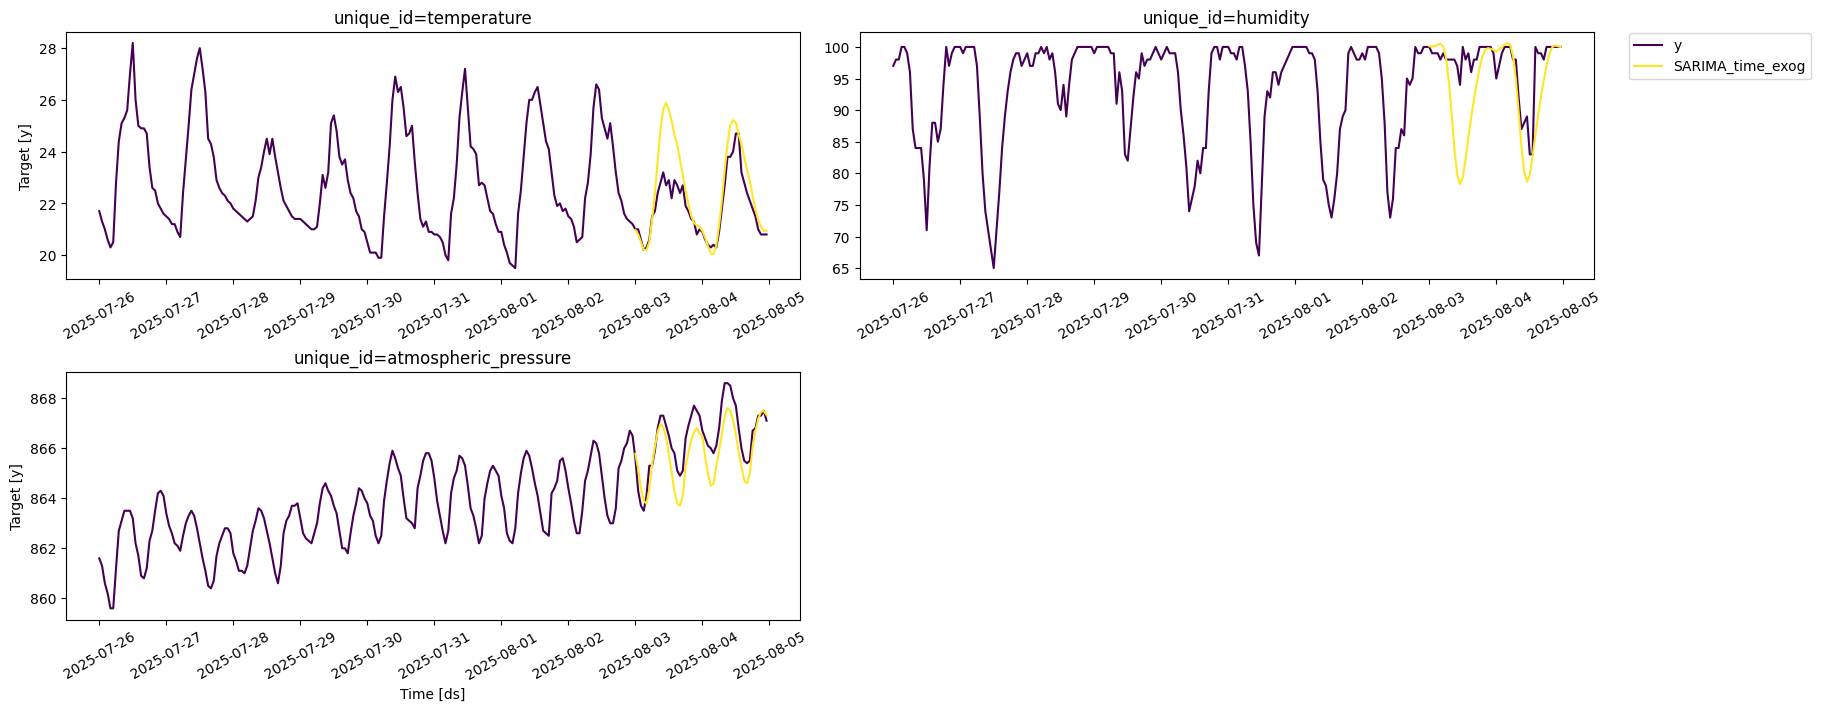

In [ ]:
plot_series(
    df=small_df,
    forecasts_df=cv_time_exog_df.drop(["y", "cutoff"], axis=1),
    ids=["temperature", "humidity", "atmospheric_pressure"],
    max_insample_length=24*30,
    palette="viridis")

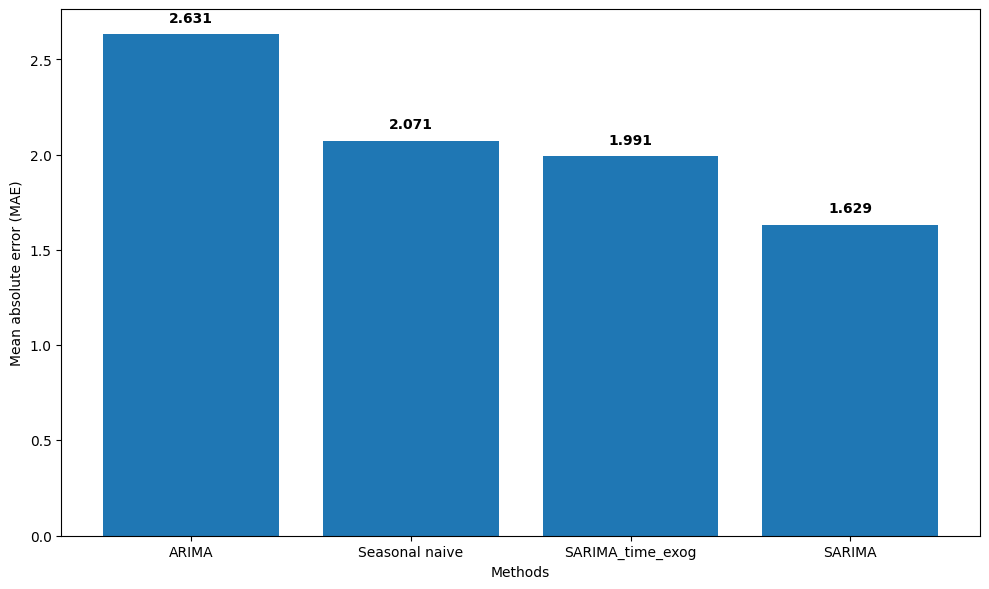

In [ ]:
methods = ["ARIMA", "Seasonal naive", "SARIMA", "SARIMA_time_exog"]
values = [2.631353, 2.070833, 1.629289, 1.990675]

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

Prediction Internals

In [ ]:
# small_df = df_long[df_long["unique_id"].isin(unique_ids)].tail(24*30*3)

In [ ]:
test = small_df.groupby("unique_id").tail(24)
train = small_df.drop(test.index).reset_index(drop=True)

In [ ]:
train.head()

ds             unique_id      y
0 2025-07-26 00:00:00  atmospheric_pressure  861.6
1 2025-07-26 00:00:00              humidity   97.0
2 2025-07-26 00:00:00           temperature   21.7
3 2025-07-26 01:00:00  atmospheric_pressure  861.3
4 2025-07-26 01:00:00              humidity   98.0

In [ ]:
models = [
    AutoARIMA(season_length=season_length)
]

sf = StatsForecast(models=models, freq="h")
sf.fit(df=train)
prob_preds = sf.predict(h=horizon, X_df=test.drop(["y"], axis=1), level=[80])

d:\Projects\weather_windows\WeatherStation\.venv\Lib\site-packages\statsforecast\arima.py:1153: UserWarning: xreg not required by this model, ignoring the provided regressors
  warnings.warn(


In [ ]:
test_df = test.merge(prob_preds, on=["unique_id", "ds"], how="left")

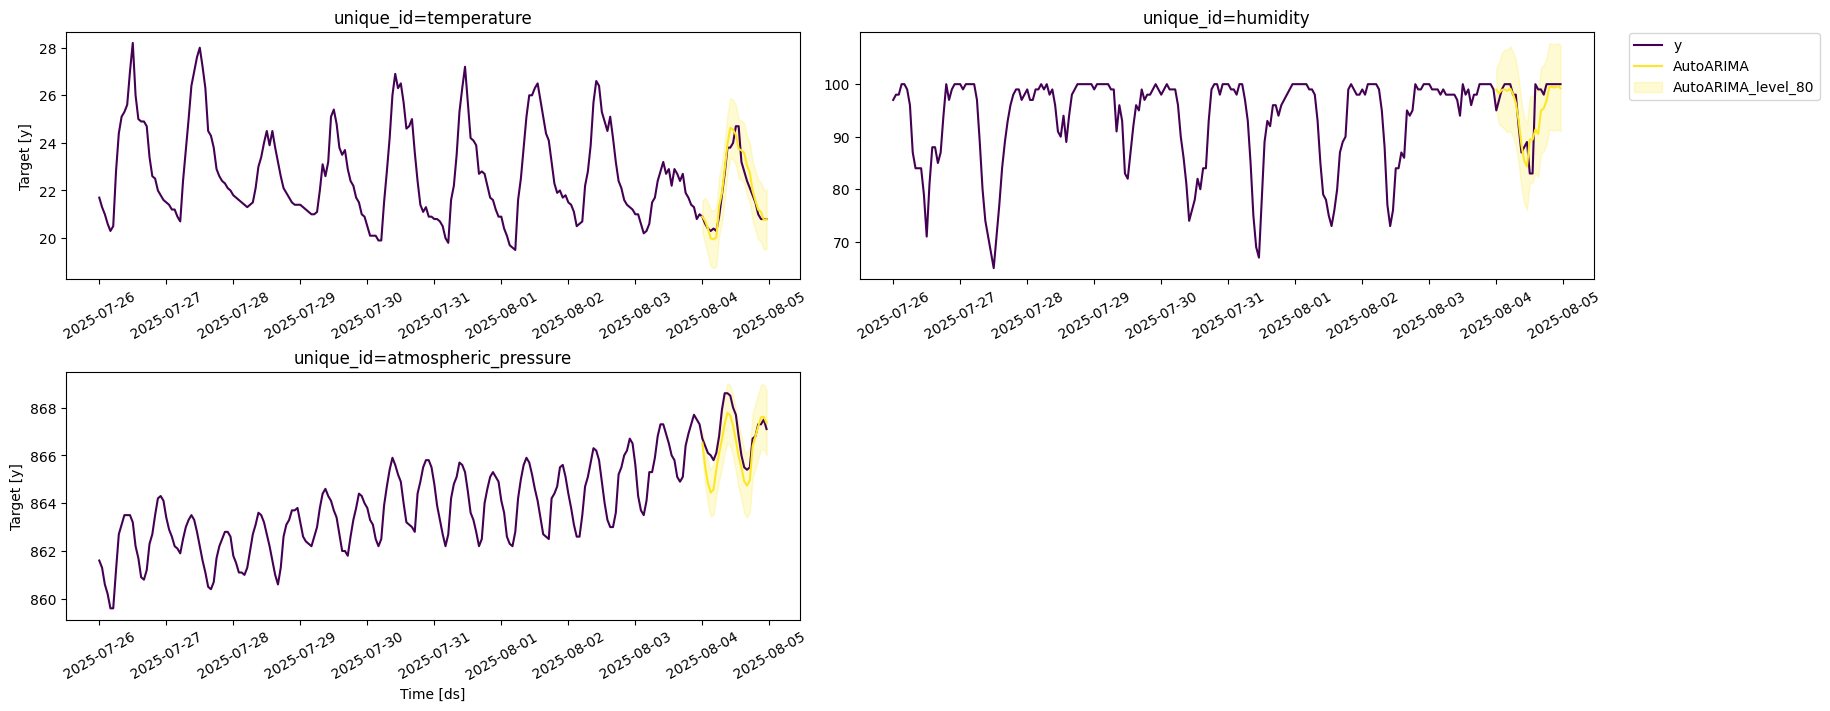

In [ ]:
plot_series(
    df=train,
    forecasts_df=test_df,
    ids=unique_ids,
    max_insample_length=24*15,
    models=["AutoARIMA"],
    level=[80],
    palette="viridis"
)

In [ ]:
models = [
    AutoARIMA(season_length=season_length, alias="SARIMA"),
]

sf = StatsForecast(models=models, freq="h")
cv_prob_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=4,
    step_size=horizon,
    refit=False,
    level=[80],
)

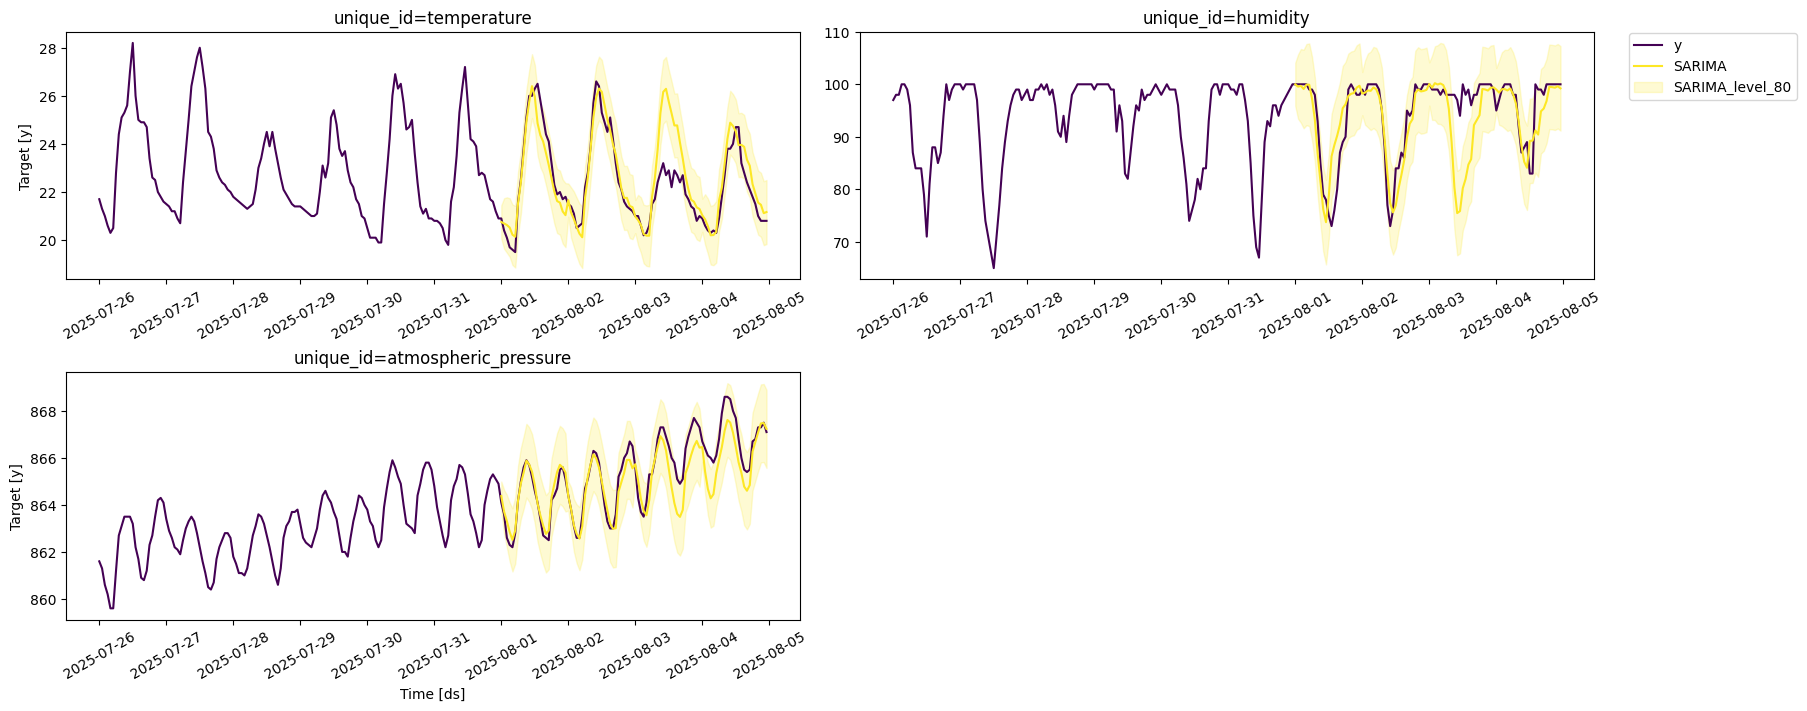

In [ ]:
plot_series(
    df=small_df,
    forecasts_df=cv_prob_df.drop(["y", "cutoff"], axis=1),
    ids=unique_ids,
    models=["SARIMA"],
    max_insample_length=24*30,
    level=[80],
    palette="viridis"
)

In [ ]:
models = [
    SeasonalNaive(season_length=season_length)
]

sf = StatsForecast(models=models, freq="h")
sn_prob_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=2,
    step_size=horizon,
    refit=True,
    level=[80],
)

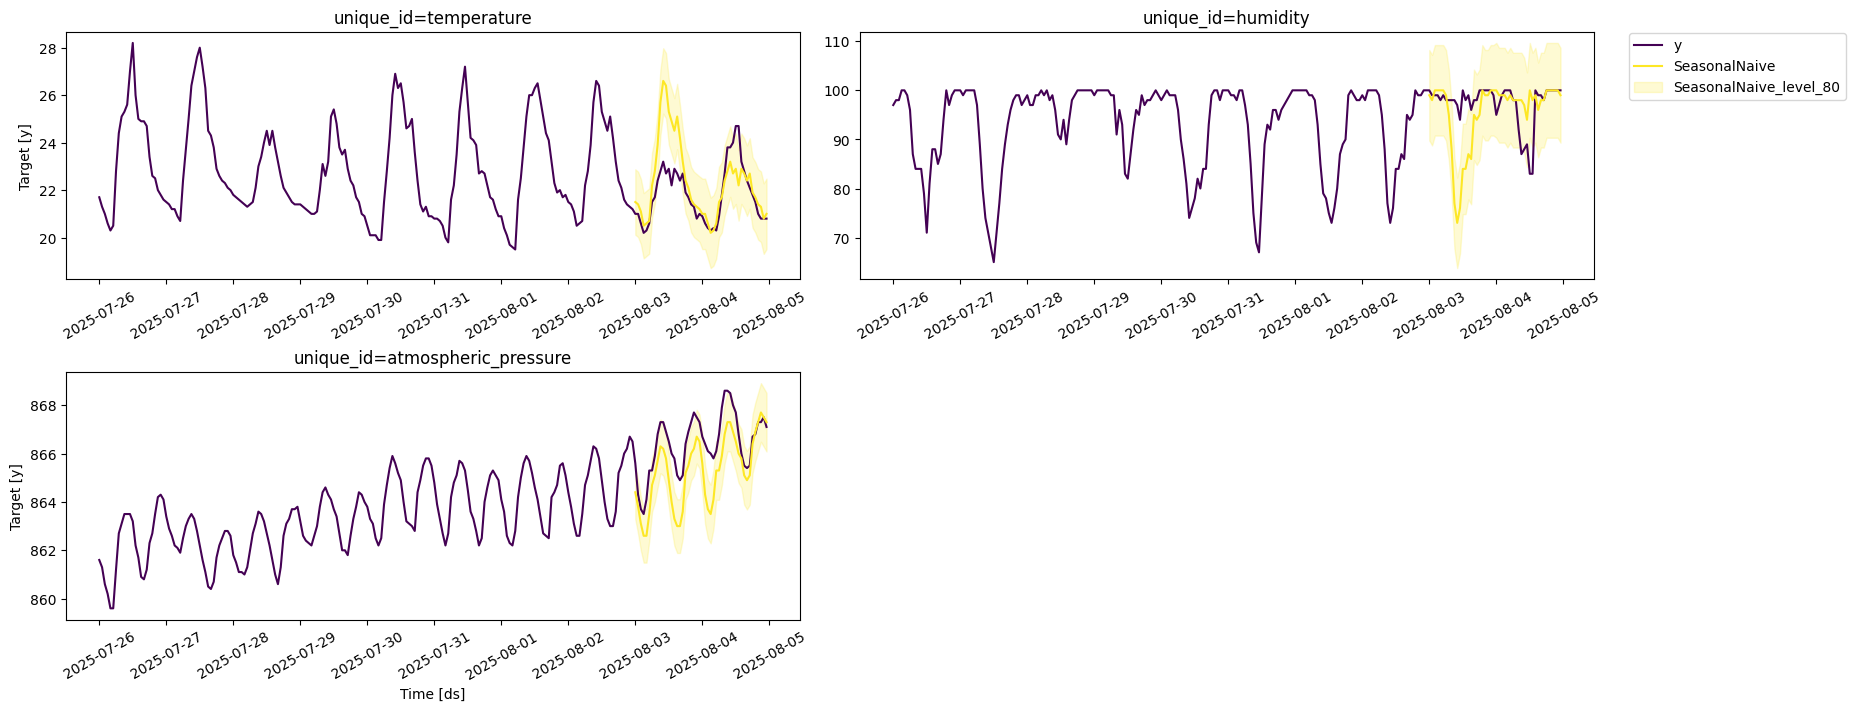

In [ ]:
plot_series(
    df=small_df,
    forecasts_df=sn_prob_df.drop(["y", "cutoff"], axis=1),
    ids=unique_ids,
    models=["SeasonalNaive"],
    max_insample_length=24*30,
    level=[80],
    palette="viridis"
)

In [ ]:
df.head()

date_time  temperature  humidity  atmospheric_pressure
0 2024-01-01 00:00:00          7.2        93                 868.0
1 2024-01-01 01:00:00          7.1        92                 867.8
2 2024-01-01 02:00:00          6.8        91                 867.4
3 2024-01-01 03:00:00          6.2        91                 866.9
4 2024-01-01 04:00:00          6.4        88                 867.2

Predition of Rain

In [ ]:
rain = pd.read_csv("./rain_data.csv", skiprows=3)

In [ ]:
rain.head()

time  rain (mm)
0  2024-01-01T00:00        0.0
1  2024-01-01T01:00        0.0
2  2024-01-01T02:00        0.0
3  2024-01-01T03:00        0.0
4  2024-01-01T04:00        0.0

In [ ]:
rain["date_time"] = pd.to_datetime(rain["time"]).dt.floor("h")
rain = rain.rename(columns={"rain (mm)": "rain_mm"})
rain_hourly = rain[["date_time", "rain_mm"]].drop_duplicates(subset="date_time")


In [ ]:
rain_hourly

date_time  rain_mm
0     2024-01-01 00:00:00      0.0
1     2024-01-01 01:00:00      0.0
2     2024-01-01 02:00:00      0.0
3     2024-01-01 03:00:00      0.0
4     2024-01-01 04:00:00      0.0
...                   ...      ...
13963 2025-08-04 19:00:00      0.8
13964 2025-08-04 20:00:00      0.3
13965 2025-08-04 21:00:00      0.1
13966 2025-08-04 22:00:00      0.1
13967 2025-08-04 23:00:00      0.0

[13968 rows x 2 columns]

In [ ]:
merged = pd.merge(rain_hourly, df, on="date_time", how="inner")


In [ ]:
merged.head(100)

date_time  rain_mm  temperature  humidity  atmospheric_pressure
0  2024-01-01 00:00:00      0.0          7.2        93                 868.0
1  2024-01-01 01:00:00      0.0          7.1        92                 867.8
2  2024-01-01 02:00:00      0.0          6.8        91                 867.4
3  2024-01-01 03:00:00      0.0          6.2        91                 866.9
4  2024-01-01 04:00:00      0.0          6.4        88                 867.2
..                 ...      ...          ...       ...                   ...
95 2024-01-04 23:00:00      0.0          5.7        85                 867.2
96 2024-01-05 00:00:00      0.0          5.1        85                 866.7
97 2024-01-05 01:00:00      0.0          7.0        76                 867.6
98 2024-01-05 02:00:00      0.0          9.2        67                 868.7
99 2024-01-05 03:00:00      0.0          9.4        63                 868.8

[100 rows x 5 columns]

In [ ]:
df_rain_long = merged.melt(
    id_vars=["date_time"],
    value_vars=["temperature", "humidity", "atmospheric_pressure", "rain_mm"],
    var_name="unique_id",
    value_name="y"
).rename(columns={"date_time": "ds"})


In [ ]:
df_rain_long.head()

ds    unique_id    y
0 2024-01-01 00:00:00  temperature  7.2
1 2024-01-01 01:00:00  temperature  7.1
2 2024-01-01 02:00:00  temperature  6.8
3 2024-01-01 03:00:00  temperature  6.2
4 2024-01-01 04:00:00  temperature  6.4

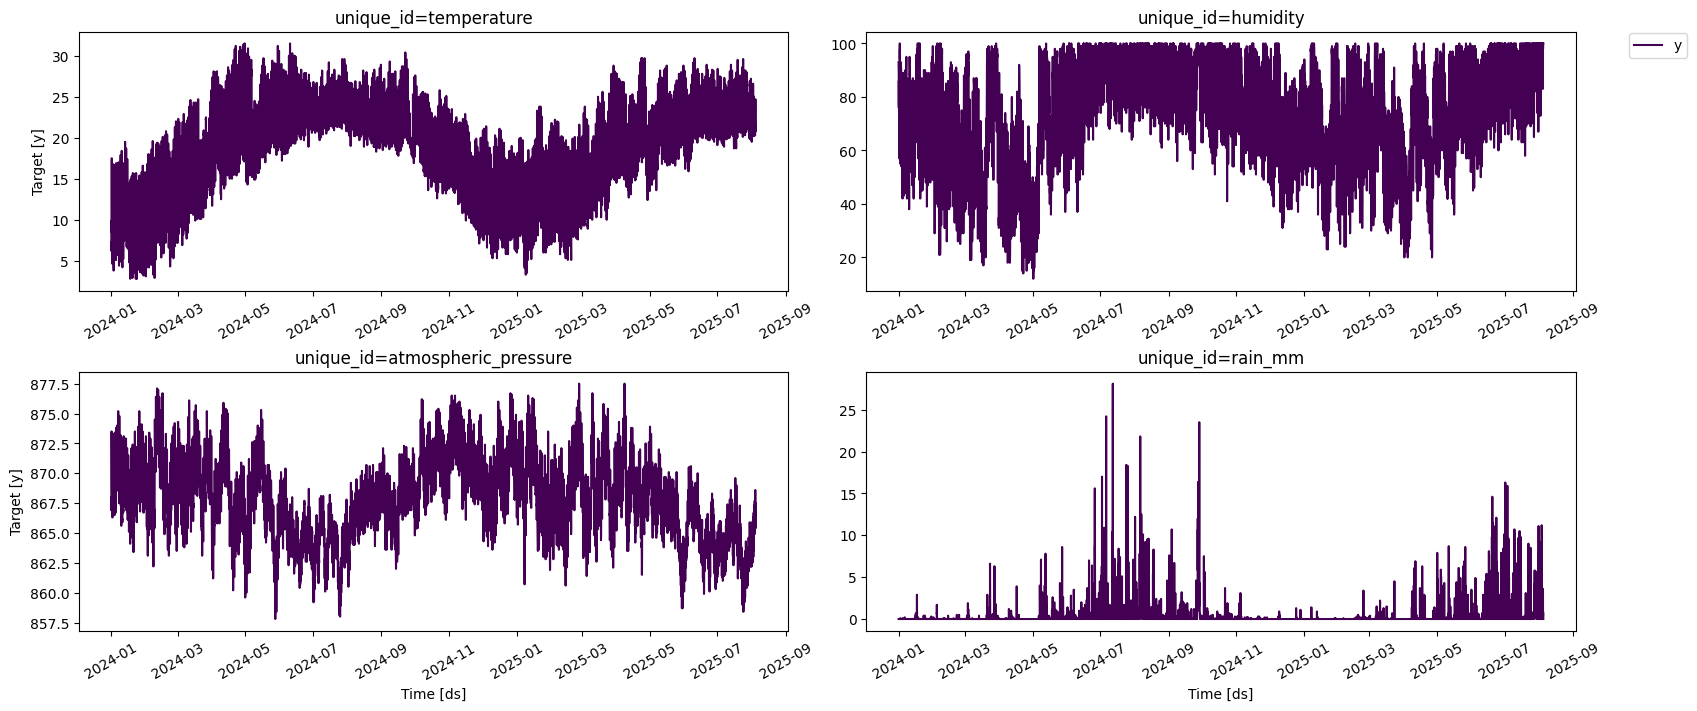

In [ ]:
plot_series(df=df_rain_long, palette="viridis")

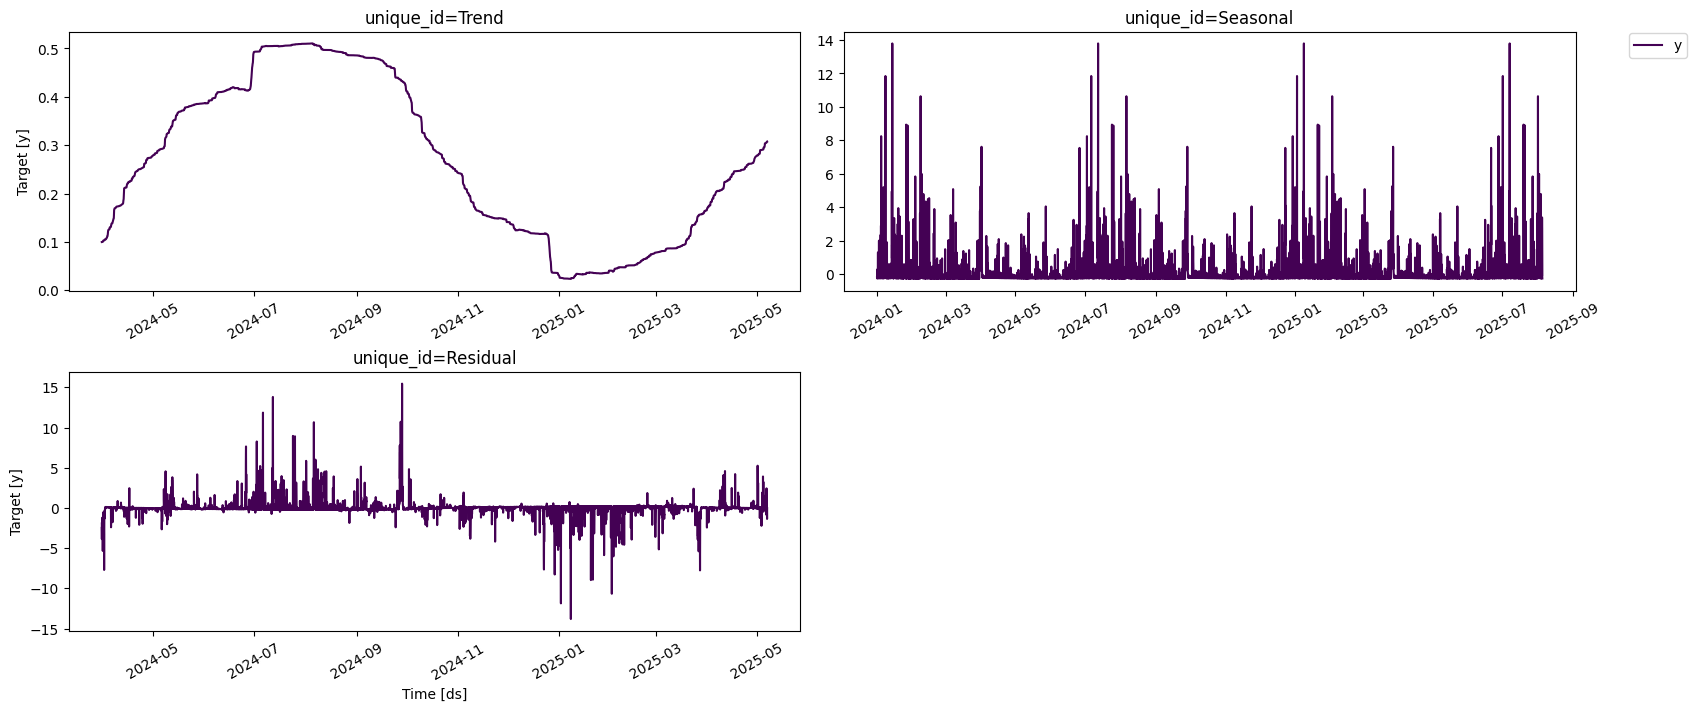

In [ ]:
var = "rain_mm"
ts = (
    df_rain_long[df_rain_long["unique_id"] == var]
    .set_index("ds")["y"]
    .asfreq("h")
)

result = seasonal_decompose(ts, model="additive", period=24*30*6)

components_long = pd.concat([
    result.trend.rename("Trend"),
    result.seasonal.rename("Seasonal"),
    result.resid.rename("Residual")
], axis=1).reset_index().melt(id_vars="ds", var_name="unique_id", value_name="y")

plot_series(
    df=pd.DataFrame({"ds": ts.index, "unique_id": var, "y": ts.values}),
    max_insample_length=24*30*6,
    forecasts_df=components_long,
    ids=["Trend", "Seasonal", "Residual"],
    palette="viridis"
)

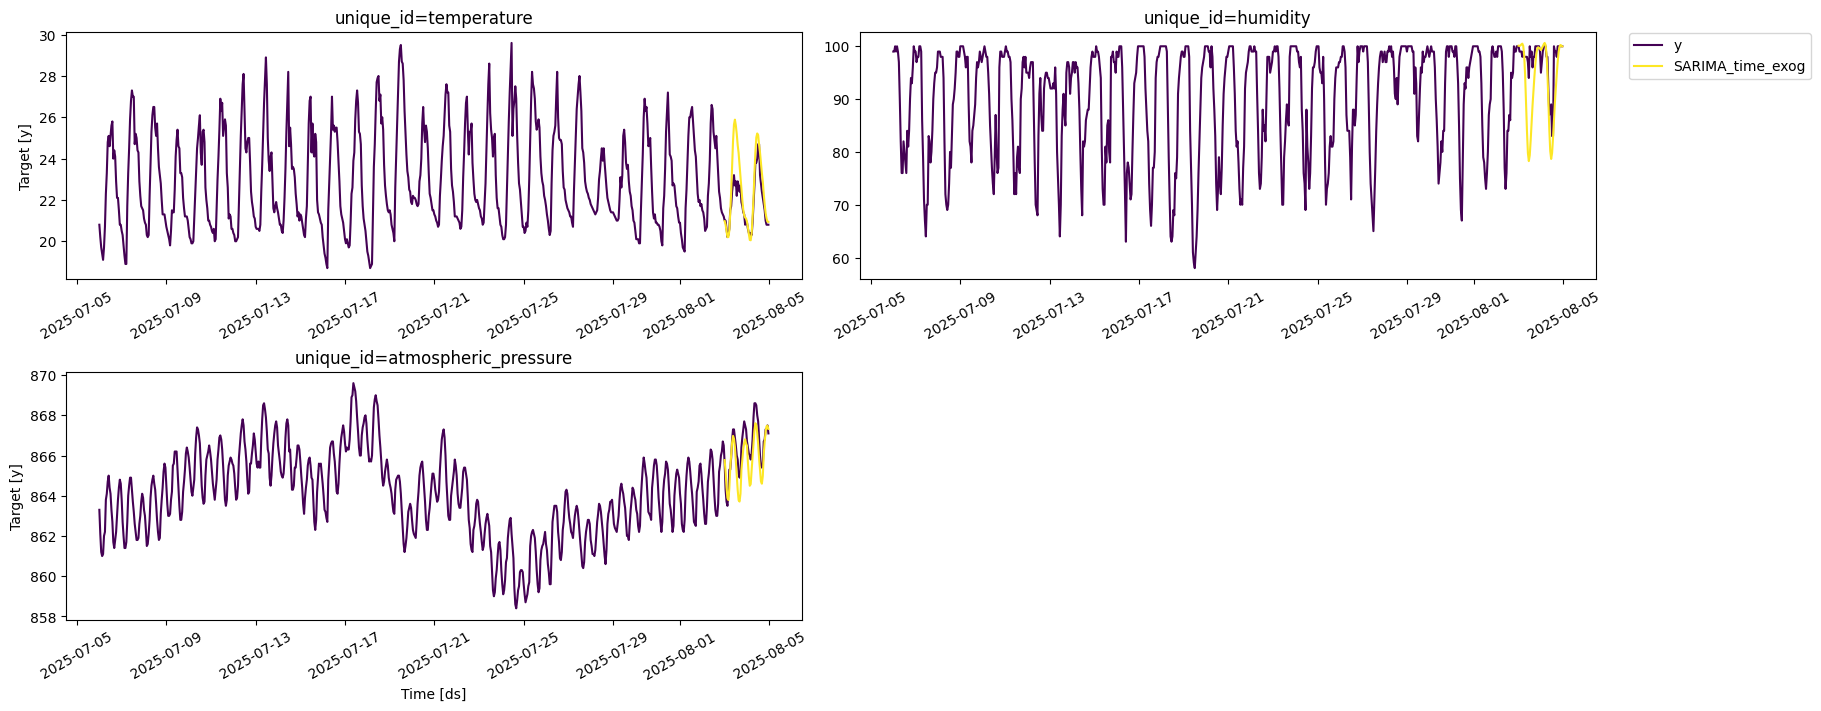

In [ ]:
plot_series(
    df=df_rain_long,
    forecasts_df=cv_time_exog_df.drop(["y", "cutoff"], axis=1),
    ids=["temperature", "humidity", "atmospheric_pressure"],
    max_insample_length=24*30,
    palette="viridis")

In [ ]:
merged

date_time  rain_mm  temperature  humidity  \
0     2024-01-01 00:00:00      0.0          7.2        93   
1     2024-01-01 01:00:00      0.0          7.1        92   
2     2024-01-01 02:00:00      0.0          6.8        91   
3     2024-01-01 03:00:00      0.0          6.2        91   
4     2024-01-01 04:00:00      0.0          6.4        88   
...                   ...      ...          ...       ...   
13963 2025-08-04 19:00:00      0.8         21.5       100   
13964 2025-08-04 20:00:00      0.3         21.0       100   
13965 2025-08-04 21:00:00      0.1         20.8       100   
13966 2025-08-04 22:00:00      0.1         20.8       100   
13967 2025-08-04 23:00:00      0.0         20.8       100   

       atmospheric_pressure  rain_event  
0                     868.0           0  
1                     867.8           0  
2                     867.4           0  
3                     866.9           0  
4                     867.2           0  
...                     ...         ...  
13963                 866.8           1  
13964                 867.3           1  
13965                 867.3           0  
13966                 867.5           0  
13967                 867.1           0  

[13968 rows x 6 columns]

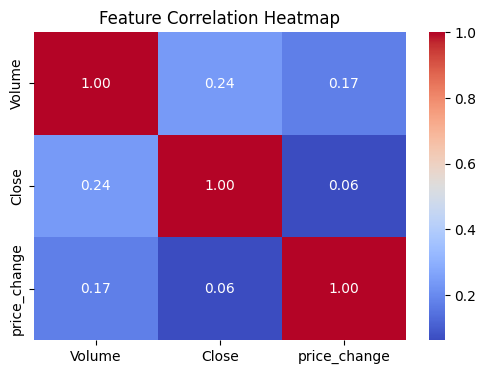

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
corr = df[["Volume", "Close","price_change"]].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

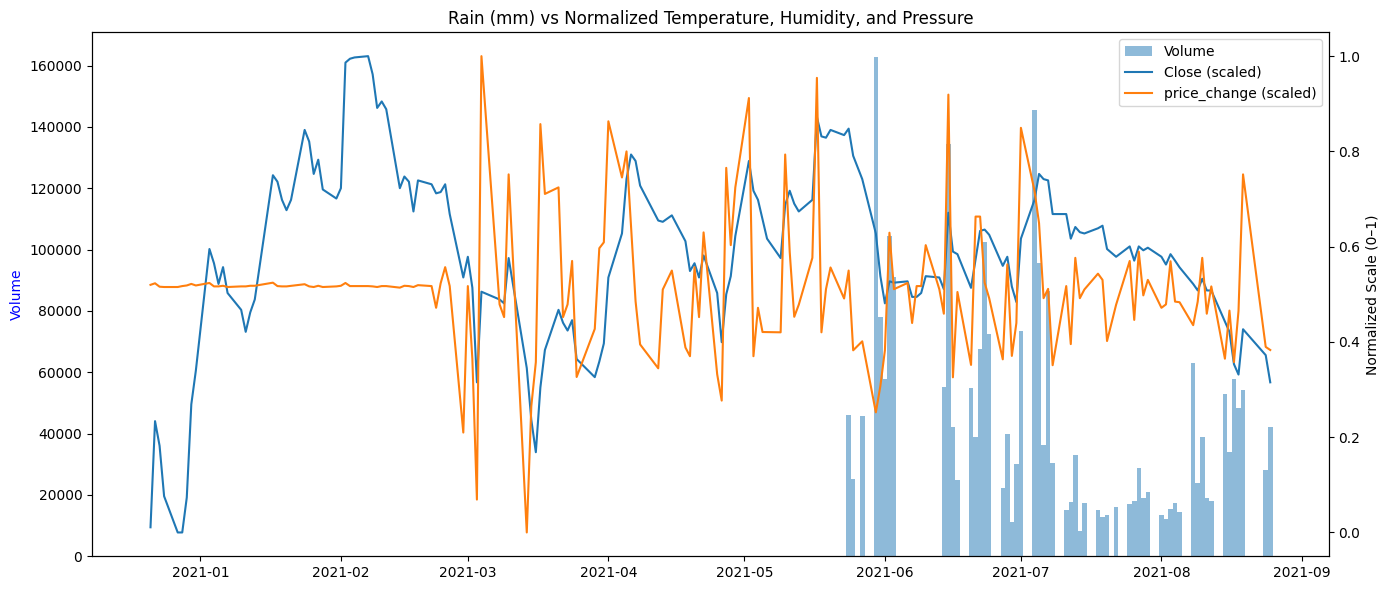

In [122]:
from sklearn.preprocessing import MinMaxScaler

line_plot = df.copy().tail(24*7)

# Normalize only temperature, humidity, pressure
cols_to_scale = ["Close", "Volume", "price_change"]

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(line_plot[cols_to_scale])
line_plot_scaled = line_plot.copy()
line_plot_scaled[cols_to_scale] = scaled_features

fig, ax1 = plt.subplots(figsize=(14,6))

ax1.bar(line_plot["Date"], line_plot["Volume"], width=1, alpha=0.5, label="Volume")
ax1.set_ylabel("Volume", color="blue")

ax2 = ax1.twinx()
ax2.plot(line_plot["Date"], line_plot_scaled["Close"], label="Close (scaled)")
# ax2.plot(line_plot["Date"], line_plot_scaled["Volume"], label="Volume (scaled)")
ax2.plot(line_plot["Date"], line_plot_scaled["price_change"], label="price_change (scaled)")
ax2.set_ylabel("Normalized Scale (0–1)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("Rain (mm) vs Normalized Temperature, Humidity, and Pressure")
plt.xlabel("Date/Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
rain_only = merged.loc[merged["rain_mm"].fillna(0).gt(0)]

In [ ]:
rain_only

date_time  rain_mm  temperature  humidity  \
37    2024-01-02 13:00:00      0.1         16.8        58   
38    2024-01-02 14:00:00      0.1         16.7        56   
85    2024-01-04 13:00:00      0.1         16.7        43   
132   2024-01-06 12:00:00      0.2         16.1        55   
133   2024-01-06 13:00:00      0.1         16.4        54   
...                   ...      ...          ...       ...   
13962 2025-08-04 18:00:00      0.7         21.8       100   
13963 2025-08-04 19:00:00      0.8         21.5       100   
13964 2025-08-04 20:00:00      0.3         21.0       100   
13965 2025-08-04 21:00:00      0.1         20.8       100   
13966 2025-08-04 22:00:00      0.1         20.8       100   

       atmospheric_pressure  
37                    870.2  
38                    869.8  
85                    870.1  
132                   871.9  
133                   871.1  
...                     ...  
13962                 866.7  
13963                 866.8  
13964                 867.3  
13965                 867.3  
13966                 867.5  

[3514 rows x 5 columns]

In [ ]:
filter_rain_only = rain_only[rain_only["rain_mm"]>0.1]
filter_rain_only

date_time  rain_mm  temperature  humidity  \
132   2024-01-06 12:00:00      0.2         16.1        55   
372   2024-01-16 12:00:00      0.5         14.3        65   
373   2024-01-16 13:00:00      0.4         13.4        64   
375   2024-01-16 15:00:00      0.7         12.7        71   
376   2024-01-16 16:00:00      0.2         11.7        81   
...                   ...      ...          ...       ...   
13960 2025-08-04 16:00:00      1.0         22.4        99   
13961 2025-08-04 17:00:00      0.3         22.1        98   
13962 2025-08-04 18:00:00      0.7         21.8       100   
13963 2025-08-04 19:00:00      0.8         21.5       100   
13964 2025-08-04 20:00:00      0.3         21.0       100   

       atmospheric_pressure  
132                   871.9  
372                   869.5  
373                   868.7  
375                   867.6  
376                   867.4  
...                     ...  
13960                 865.4  
13961                 865.5  
13962                 866.7  
13963                 866.8  
13964                 867.3  

[2366 rows x 5 columns]

In [ ]:
summary = filter_rain_only[["temperature", "humidity", "atmospheric_pressure"]].agg(["min", "max", "mean"])
print(summary)


      temperature    humidity  atmospheric_pressure
min      8.600000   30.000000            858.000000
max     29.800000  100.000000            876.900000
mean    22.276712   84.573119            866.027388


In [ ]:
filter_rain_only["temperature"].describe()


count    2366.000000
mean       22.276712
std         3.319379
min         8.600000
25%        20.900000
50%        22.200000
75%        24.600000
max        29.800000
Name: temperature, dtype: float64

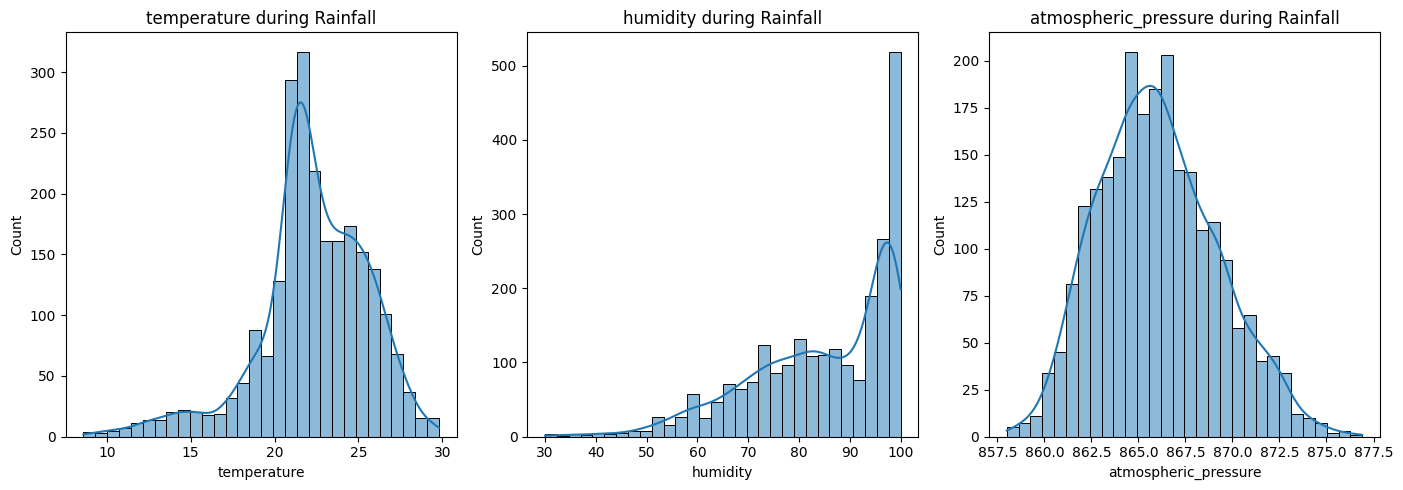

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
for i, col in enumerate(["price_change", "Close"], 1):
    plt.subplot(1,3,i)
    sns.histplot(filter_rain_only[col], bins=30, kde=True)
    plt.title(f"{col} during Rainfall")
plt.tight_layout()
plt.show()


In [ ]:
merged["rain_event"] = (merged["rain_mm"] > 0.1).astype(int)


In [ ]:
def prob_rain(condition):
    return np.mean(merged.loc[condition, "rain_event"])

print("P(rain | humidity > 90%) =", prob_rain(merged["humidity"] > 90))
print("P(rain | pressure < 870) =", prob_rain(merged["atmospheric_pressure"] < 870))
print("P(rain | temperature < 15) =", prob_rain(merged["temperature"] < 15))


P(rain | humidity > 90%) = 0.24654323880946802
P(rain | pressure < 870) = 0.1967629622659264
P(rain | temperature < 15) = 0.02575991756826378


Accuracy: 0.8285612025769507


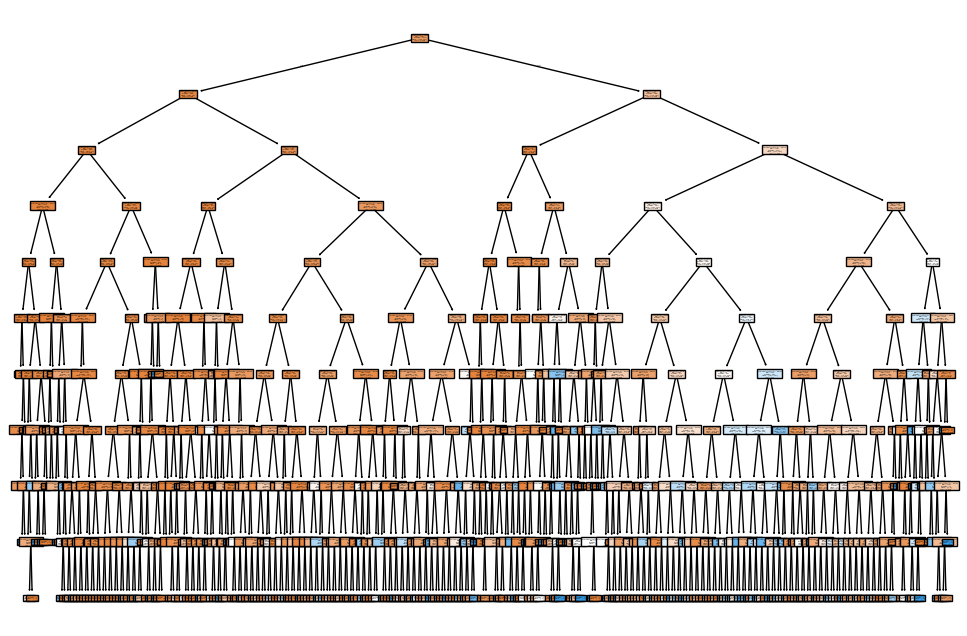

Decision Tree Rules for Rain Prediction:

|--- temperature <= 20.55
|   |--- temperature <= 16.75
|   |   |--- temperature <= 11.65
|   |   |   |--- atmospheric_pressure <= 869.75
|   |   |   |   |--- humidity <= 90.50
|   |   |   |   |   |--- temperature <= 9.55
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- temperature >  9.55
|   |   |   |   |   |   |--- temperature <= 9.65
|   |   |   |   |   |   |   |--- atmospheric_pressure <= 867.35
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- atmospheric_pressure >  867.35
|   |   |   |   |   |   |   |   |--- atmospheric_pressure <= 867.70
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- atmospheric_pressure >  867.70
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- temperature >  9.65
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- humidity >  90.50
|   |   |   |   |   |--- temperature <= 10.05
|   |   |   |   | 

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text,plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Features and target
X = merged[["temperature", "humidity", "atmospheric_pressure"]]
y = merged["rain_event"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple tree (limit depth so rules are easy to interpret)
tree = DecisionTreeClassifier(max_depth=10)
tree.fit(X_train, y_train)

# Check accuracy
y_pred = tree.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree, filled=True, feature_names=X.columns, class_names=["No Rain", "Rain"])
plt.show()

rules = export_text(tree, feature_names=list(X.columns))
print("Decision Tree Rules for Rain Prediction:\n")
print(rules)

In [ ]:
result = filter_rain_only[['temperature', 'humidity', 'atmospheric_pressure']].quantile([0.25, 0.75]).T


In [ ]:
result.columns = ['low', 'high']


In [ ]:
result.head()

low   high
temperature            20.9   24.6
humidity               75.0   97.0
atmospheric_pressure  863.7  868.1

In [ ]:
ranges_overall = rain_only.quantile([0.25, 0.75]).T.rename(columns={0.25:"low", 0.75:"high"})
ranges_overall

low                 high
date_time             2024-07-11 11:15:00  2025-05-26 12:45:00
rain_mm                               0.1                  0.8
temperature                          20.8                 24.9
humidity                             72.0                 97.0
atmospheric_pressure                864.0              868.575

In [ ]:
cv_prob_df

unique_id                  ds              cutoff      y  \
0    atmospheric_pressure 2025-08-01 00:00:00 2025-07-31 23:00:00  864.1   
1    atmospheric_pressure 2025-08-01 01:00:00 2025-07-31 23:00:00  863.6   
2    atmospheric_pressure 2025-08-01 02:00:00 2025-07-31 23:00:00  862.6   
3    atmospheric_pressure 2025-08-01 03:00:00 2025-07-31 23:00:00  862.3   
4    atmospheric_pressure 2025-08-01 04:00:00 2025-07-31 23:00:00  862.2   
..                    ...                 ...                 ...    ...   
283           temperature 2025-08-04 19:00:00 2025-08-03 23:00:00   21.5   
284           temperature 2025-08-04 20:00:00 2025-08-03 23:00:00   21.0   
285           temperature 2025-08-04 21:00:00 2025-08-03 23:00:00   20.8   
286           temperature 2025-08-04 22:00:00 2025-08-03 23:00:00   20.8   
287           temperature 2025-08-04 23:00:00 2025-08-03 23:00:00   20.8   

         SARIMA  SARIMA-lo-80  SARIMA-hi-80  
0    864.375905    863.756926    864.994884  
1    863.712292    862.782268    864.642316  
2    863.312335    862.194439    864.430231  
3    862.850890    861.603120    864.098660  
4    862.511401    861.168914    863.853889  
..          ...           ...           ...  
283   21.937897     20.606866     23.268928  
284   21.558348     20.227270     22.889426  
285   21.468872     20.137762     22.799981  
286   21.119513     19.788384     22.450641  
287   21.166693     19.835554     22.497831  

[288 rows x 7 columns]

In [ ]:
cv_df.head()

unique_id                  ds              cutoff      y  \
0  atmospheric_pressure 2025-08-01 00:00:00 2025-07-31 23:00:00  864.1   
1  atmospheric_pressure 2025-08-01 01:00:00 2025-07-31 23:00:00  863.6   
2  atmospheric_pressure 2025-08-01 02:00:00 2025-07-31 23:00:00  862.6   
3  atmospheric_pressure 2025-08-01 03:00:00 2025-07-31 23:00:00  862.3   
4  atmospheric_pressure 2025-08-01 04:00:00 2025-07-31 23:00:00  862.2   

        ARIMA      SARIMA  
0  864.401044  864.375905  
1  863.821631  863.712292  
2  863.408240  863.312335  
3  863.246310  862.850890  
4  863.319415  862.511401

In [ ]:
pred_wide = cv_prob_df.pivot_table(
    index="ds",
    columns="unique_id",
    values=["SARIMA", "SARIMA-lo-80", "SARIMA-hi-80"]
).reset_index()

# Flatten multiindex
pred_wide.columns = ["_".join(col).strip() for col in pred_wide.columns.values]
pred_wide = pred_wide.reset_index()
pred_wide["ds"] = pd.to_datetime(pred_wide["ds_"])
pred_wide.drop(columns=["ds_"], inplace=True)
pred_wide


index  SARIMA_atmospheric_pressure  SARIMA_humidity  SARIMA_temperature  \
0       0                   864.375905        99.988530           20.753667   
1       1                   863.712292        99.554780           20.690638   
2       2                   863.312335        99.702329           20.627478   
3       3                   862.850890        99.103014           20.523113   
4       4                   862.511401        99.934591           20.224030   
..    ...                          ...              ...                 ...   
91     91                   866.676085        99.508445           21.937897   
92     92                   867.090574        99.459584           21.558348   
93     93                   867.468468        99.350308           21.468872   
94     94                   867.483092        99.628137           21.119513   
95     95                   867.235316        99.228158           21.166693   

    SARIMA-hi-80_atmospheric_pressure  SARIMA-hi-80_humidity  \
0                          864.994884             104.109589   
1                          864.642316             105.677775   
2                          864.430231             106.716460   
3                          864.098660             106.578371   
4                          863.853889             107.660904   
..                                ...                    ...   
91                         868.331688             107.554576   
92                         868.748201             107.505743   
93                         869.127709             107.396480   
94                         869.143621             107.674313   
95                         868.896873             107.274329   

    SARIMA-hi-80_temperature  SARIMA-lo-80_atmospheric_pressure  \
0                  21.444107                         863.756926   
1                  21.738777                         862.782268   
2                  21.779929                         862.194439   
3                  21.739503                         861.603120   
4                  21.480828                         861.168914   
..                       ...                                ...   
91                 23.268928                         865.020483   
92                 22.889426                         865.432948   
93                 22.799981                         865.809226   
94                 22.450641                         865.822563   
95                 22.497831                         865.573759   

    SARIMA-lo-80_humidity  SARIMA-lo-80_temperature                  ds  
0               95.867472                 20.063227 2025-08-01 00:00:00  
1               93.431786                 19.642499 2025-08-01 01:00:00  
2               92.688198                 19.475027 2025-08-01 02:00:00  
3               91.627658                 19.306723 2025-08-01 03:00:00  
4               92.208279                 18.967231 2025-08-01 04:00:00  
..                    ...                       ...                 ...  
91              91.462315                 20.606866 2025-08-04 19:00:00  
92              91.413426                 20.227270 2025-08-04 20:00:00  
93              91.304135                 20.137762 2025-08-04 21:00:00  
94              91.581961                 19.788384 2025-08-04 22:00:00  
95              91.181987                 19.835554 2025-08-04 23:00:00  

[96 rows x 11 columns]

In [ ]:
X_point = pred_wide.rename(columns={
    "SARIMA_temperature": "temperature",
    "SARIMA_humidity": "humidity",
    "SARIMA_atmospheric_pressure": "atmospheric_pressure"
})[["temperature", "humidity", "atmospheric_pressure"]]
pred_wide["rain_pred_point"] = tree.predict(X_point)
pred_wide["rain_prob_point"] = tree.predict_proba(X_point)[:,1]


In [ ]:
X_lo = pred_wide.rename(columns={
    "SARIMA-lo-80_temperature": "temperature",
    "SARIMA-lo-80_humidity": "humidity",
    "SARIMA-lo-80_atmospheric_pressure": "atmospheric_pressure"
})[["temperature", "humidity", "atmospheric_pressure"]]

pred_wide["rain_prob_lo"] = tree.predict_proba(X_lo)[:, 1]

X_hi = pred_wide.rename(columns={
    "SARIMA-hi-80_temperature": "temperature",
    "SARIMA-hi-80_humidity": "humidity",
    "SARIMA-hi-80_atmospheric_pressure": "atmospheric_pressure"
})[["temperature", "humidity", "atmospheric_pressure"]]

pred_wide["rain_prob_hi"] = tree.predict_proba(X_hi)[:, 1]


In [ ]:
# Make sure both have datetime dtype
merged["date_time"] = pd.to_datetime(merged["date_time"])
pred_wide["ds"] = pd.to_datetime(pred_wide["ds"])

# Merge actuals with predictions
eval_df = pd.merge(merged, pred_wide, left_on="date_time", right_on="ds", how="inner")


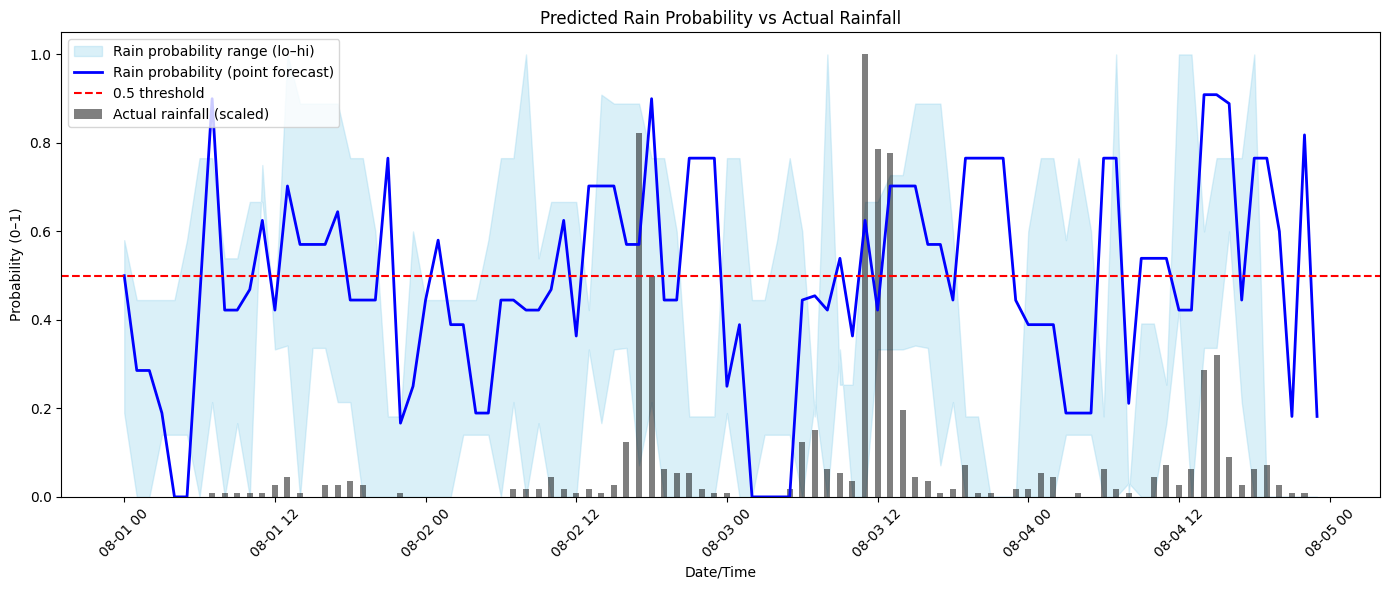

In [ ]:
plt.figure(figsize=(14,6))

# Rain probability range (lo–hi from SARIMA uncertainty)
plt.fill_between(
    eval_df["date_time"],
    eval_df["rain_prob_lo"],
    eval_df["rain_prob_hi"],
    color="skyblue", alpha=0.3, label="Rain probability range (lo–hi)"
)

# Point probability
plt.plot(
    eval_df["date_time"],
    eval_df["rain_prob_point"],
    color="blue", linewidth=2, label="Rain probability (point forecast)"
)

# Threshold
plt.axhline(0.5, color="red", linestyle="--", label="0.5 threshold")

# Actual rainfall (scaled 0–1)
if eval_df["rain_mm"].max() > 0:
    plt.bar(
        eval_df["date_time"],
        eval_df["rain_mm"] / eval_df["rain_mm"].max(),
        width=0.02,
        alpha=0.5,
        color="black",
        label="Actual rainfall (scaled)"
    )

plt.title("Predicted Rain Probability vs Actual Rainfall")
plt.xlabel("Date/Time")
plt.ylabel("Probability (0–1)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# fc = (
#     cv_df
#     .pivot(index="ds", columns="unique_id", values="SARIMA")
#     .reset_index()
# )
# fc = cv_df

fc = (
    cv_df.sort_values(["ds", "unique_id", "cutoff"])
         .groupby(["ds", "unique_id"], as_index=False)
         .last()  # last cutoff = latest forecast for that timestamp
         .pivot(index="ds", columns="unique_id", values=["y", "SARIMA"])
         .reset_index()
)

fc.columns = ['ds'] + [f"{col}_{var}" for col, var in fc.columns[1:]]

fc = fc.rename(columns={
    "SARIMA_temperature": "predicted_temperature",
    "SARIMA_humidity": "predicted_humidity",
    "SARIMA_atmospheric_pressure": "predicted_atmospheric_pressure"
})

In [ ]:
fc.head()

ds  y_atmospheric_pressure  y_humidity  y_temperature  \
0 2025-08-01 00:00:00                   864.1       100.0           20.9   
1 2025-08-01 01:00:00                   863.6       100.0           20.4   
2 2025-08-01 02:00:00                   862.6       100.0           20.1   
3 2025-08-01 03:00:00                   862.3       100.0           19.7   
4 2025-08-01 04:00:00                   862.2       100.0           19.6   

   predicted_atmospheric_pressure  predicted_humidity  predicted_temperature  
0                      864.375905           99.988530              20.753667  
1                      863.712292           99.554780              20.690638  
2                      863.312335           99.702329              20.627478  
3                      862.850890           99.103014              20.523113  
4                      862.511401           99.934591              20.224030

In [ ]:
# fc["in_y_temperature"] = fc["y_temperature"].between(ranges_overall.loc["temperature", "low"], ranges_overall.loc["temperature", "high"])
# fc["in_y_humidity"] = fc["y_humidity"].between(ranges_overall.loc["humidity", "low"], ranges_overall.loc["humidity", "high"])
# fc["in_y_pressure"] = fc["y_atmospheric_pressure"].between(
#     ranges_overall.loc["atmospheric_pressure", "low"], ranges_overall.loc["atmospheric_pressure", "high"]
# )
fc["in_pred_temperature"] = fc["predicted_temperature"].between(
    ranges_overall.loc["temperature", "low"], ranges_overall.loc["temperature", "high"]
)
fc["in_pred_humidity"] = fc["predicted_humidity"].between(
    ranges_overall.loc["humidity", "low"], ranges_overall.loc["humidity", "high"]
)
fc["in_pred_pressure"] = fc["predicted_atmospheric_pressure"].between(
    ranges_overall.loc["atmospheric_pressure", "low"], ranges_overall.loc["atmospheric_pressure", "high"]
)

In [ ]:
fc.head()

ds  y_atmospheric_pressure  y_humidity  y_temperature  \
0 2025-08-01 00:00:00                   864.1       100.0           20.9   
1 2025-08-01 01:00:00                   863.6       100.0           20.4   
2 2025-08-01 02:00:00                   862.6       100.0           20.1   
3 2025-08-01 03:00:00                   862.3       100.0           19.7   
4 2025-08-01 04:00:00                   862.2       100.0           19.6   

   predicted_atmospheric_pressure  predicted_humidity  predicted_temperature  \
0                      864.375905           99.988530              20.753667   
1                      863.712292           99.554780              20.690638   
2                      863.312335           99.702329              20.627478   
3                      862.850890           99.103014              20.523113   
4                      862.511401           99.934591              20.224030   

   in_pred_temperature  in_pred_humidity  in_pred_pressure  
0                False             False              True  
1                False             False             False  
2                False             False             False  
3                False             False             False  
4                False             False             False

In [ ]:
# fc["hits"] = fc[["in_y_temperature", "in_y_humidity", "in_y_pressure"]].sum(axis=1)
fc["hits_pred"] = fc[["in_pred_temperature", "in_pred_humidity", "in_pred_pressure"]].sum(axis=1)
# fc["rain_pred_for_y"] = fc["hits"] >= 3
fc["rain_pred_for_pred"] = fc["hits_pred"] >= 3

In [ ]:
result = fc[["ds", "y_temperature", "y_humidity", "y_atmospheric_pressure", "predicted_temperature", "predicted_humidity", "predicted_atmospheric_pressure", "rain_pred_for_pred"]]
result.head()

ds  y_temperature  y_humidity  y_atmospheric_pressure  \
0 2025-08-01 00:00:00           20.9       100.0                   864.1   
1 2025-08-01 01:00:00           20.4       100.0                   863.6   
2 2025-08-01 02:00:00           20.1       100.0                   862.6   
3 2025-08-01 03:00:00           19.7       100.0                   862.3   
4 2025-08-01 04:00:00           19.6       100.0                   862.2   

   predicted_temperature  predicted_humidity  predicted_atmospheric_pressure  \
0              20.753667           99.988530                      864.375905   
1              20.690638           99.554780                      863.712292   
2              20.627478           99.702329                      863.312335   
3              20.523113           99.103014                      862.850890   
4              20.224030           99.934591                      862.511401   

   rain_pred_for_pred  
0               False  
1               False  
2               False  
3               False  
4               False

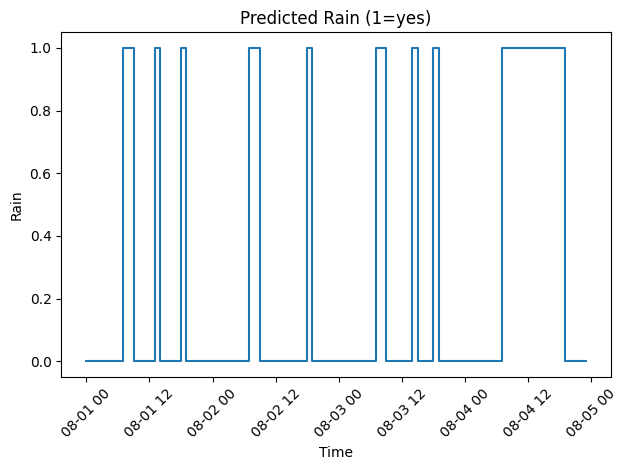

In [ ]:
plot_df = result.copy()
plot_df["ds"] = pd.to_datetime(plot_df["ds"])
plot_df = plot_df.sort_values("ds")
rain_idx = plot_df["rain_pred_for_pred"]

# 1) Predicted rain (1=yes, 0=no)
plt.figure()
plt.step(plot_df["ds"], rain_idx.astype(int), where="post")
plt.title("Predicted Rain (1=yes)")
plt.xlabel("Time")
plt.ylabel("Rain")
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()



In [ ]:
# rain["date_time"] = pd.to_datetime(rain["time"]).dt.floor("h")
# rain = rain.rename(columns={"rain (mm)": "rain_mm", "precipitation (mm)": "precipitation_mm"})
# rain_hourly = rain[["date_time", "rain_mm", "precipitation_mm"]].drop_duplicates(subset="date_time")
rain_df = rain_hourly.copy()
rain_df["ds"] = pd.to_datetime(rain_df["date_time"]).dt.floor("h")
rain_df = rain_df[["ds", "rain_mm"]].drop_duplicates(subset="ds")
rain_df.head()

ds  rain_mm
0 2024-01-01 00:00:00      0.0
1 2024-01-01 01:00:00      0.0
2 2024-01-01 02:00:00      0.0
3 2024-01-01 03:00:00      0.0
4 2024-01-01 04:00:00      0.0

In [ ]:
merged_data = pd.merge(rain_df, result, on="ds", how="inner")

In [ ]:
merged_data

ds  rain_mm  y_temperature  y_humidity  \
0  2025-08-01 00:00:00      0.0           20.9       100.0   
1  2025-08-01 01:00:00      0.0           20.4       100.0   
2  2025-08-01 02:00:00      0.0           20.1       100.0   
3  2025-08-01 03:00:00      0.0           19.7       100.0   
4  2025-08-01 04:00:00      0.0           19.6       100.0   
..                 ...      ...            ...         ...   
91 2025-08-04 19:00:00      0.8           21.5       100.0   
92 2025-08-04 20:00:00      0.3           21.0       100.0   
93 2025-08-04 21:00:00      0.1           20.8       100.0   
94 2025-08-04 22:00:00      0.1           20.8       100.0   
95 2025-08-04 23:00:00      0.0           20.8       100.0   

    y_atmospheric_pressure  predicted_temperature  predicted_humidity  \
0                    864.1              20.753667           99.988530   
1                    863.6              20.690638           99.554780   
2                    862.6              20.627478           99.702329   
3                    862.3              20.523113           99.103014   
4                    862.2              20.224030           99.934591   
..                     ...                    ...                 ...   
91                   866.8              21.937897           99.508445   
92                   867.3              21.558348           99.459584   
93                   867.3              21.468872           99.350308   
94                   867.5              21.119513           99.628137   
95                   867.1              21.166693           99.228158   

    predicted_atmospheric_pressure  rain_pred_for_pred  
0                       864.375905               False  
1                       863.712292               False  
2                       863.312335               False  
3                       862.850890               False  
4                       862.511401               False  
..                             ...                 ...  
91                      866.676085               False  
92                      867.090574               False  
93                      867.468468               False  
94                      867.483092               False  
95                      867.235316               False  

[96 rows x 9 columns]

In [ ]:
merged_data.head()

ds  rain_mm  y_temperature  y_humidity  \
0 2025-08-03 00:00:00      0.1           21.0       100.0   
1 2025-08-03 01:00:00      0.0           21.0        99.0   
2 2025-08-03 02:00:00      0.0           20.6        99.0   
3 2025-08-03 03:00:00      0.0           20.2        99.0   
4 2025-08-03 04:00:00      0.0           20.3        98.0   

   y_atmospheric_pressure  predicted_temperature  predicted_humidity  \
0                   865.6              21.349982           98.794914   
1                   864.3              21.604358           97.066089   
2                   863.7              21.925038           95.303115   
3                   863.5              22.254590           93.802853   
4                   864.1              22.555347           92.699804   

   predicted_atmospheric_pressure  rain_pred_for_pred  
0                      865.522406               False  
1                      864.391709               False  
2                      863.285781               False  
3                      862.479153               False  
4                      862.158990               False

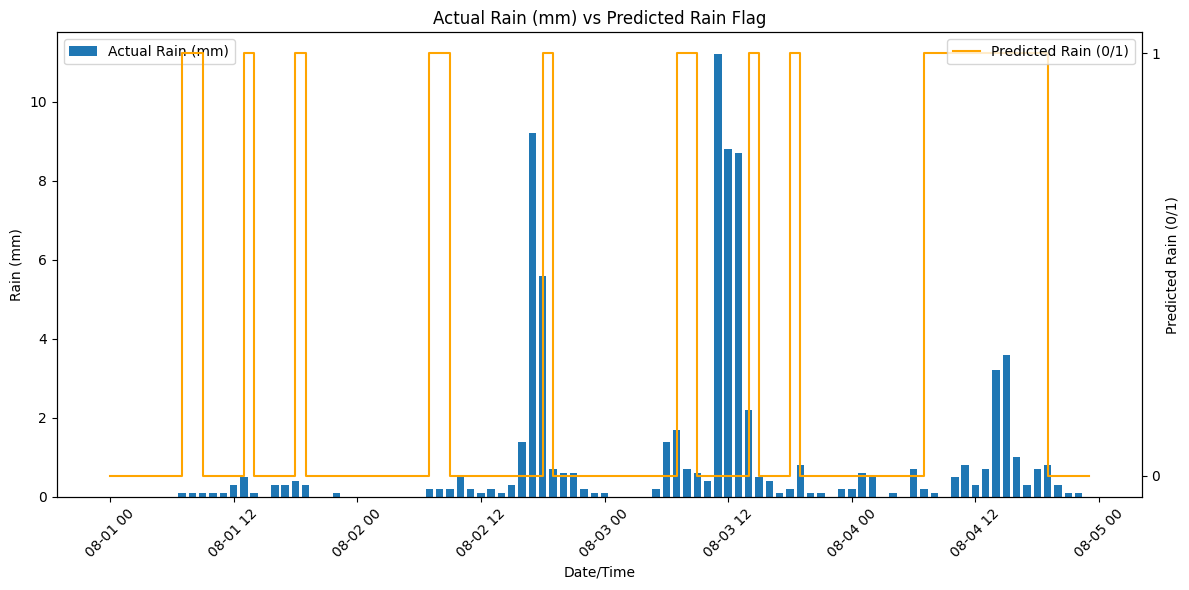

In [ ]:
df_plot = merged_data.copy()
df_plot["ds"] = pd.to_datetime(df_plot["ds"])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bars for actual rain_mm
ax1.bar(df_plot["ds"], df_plot["rain_mm"], width=0.03, label="Actual Rain (mm)")
ax1.set_ylabel("Rain (mm)")
ax1.set_xlabel("Date/Time")
ax1.tick_params(axis="x", rotation=45)

# Second y-axis for predicted rain flag
ax2 = ax1.twinx()
ax2.step(df_plot["ds"], df_plot["rain_pred_for_pred"].astype(int),
         where="post", color="orange", label="Predicted Rain (0/1)")
ax2.set_ylabel("Predicted Rain (0/1)")
ax2.set_yticks([0, 1])

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.title("Actual Rain (mm) vs Predicted Rain Flag")
plt.tight_layout()
plt.show()

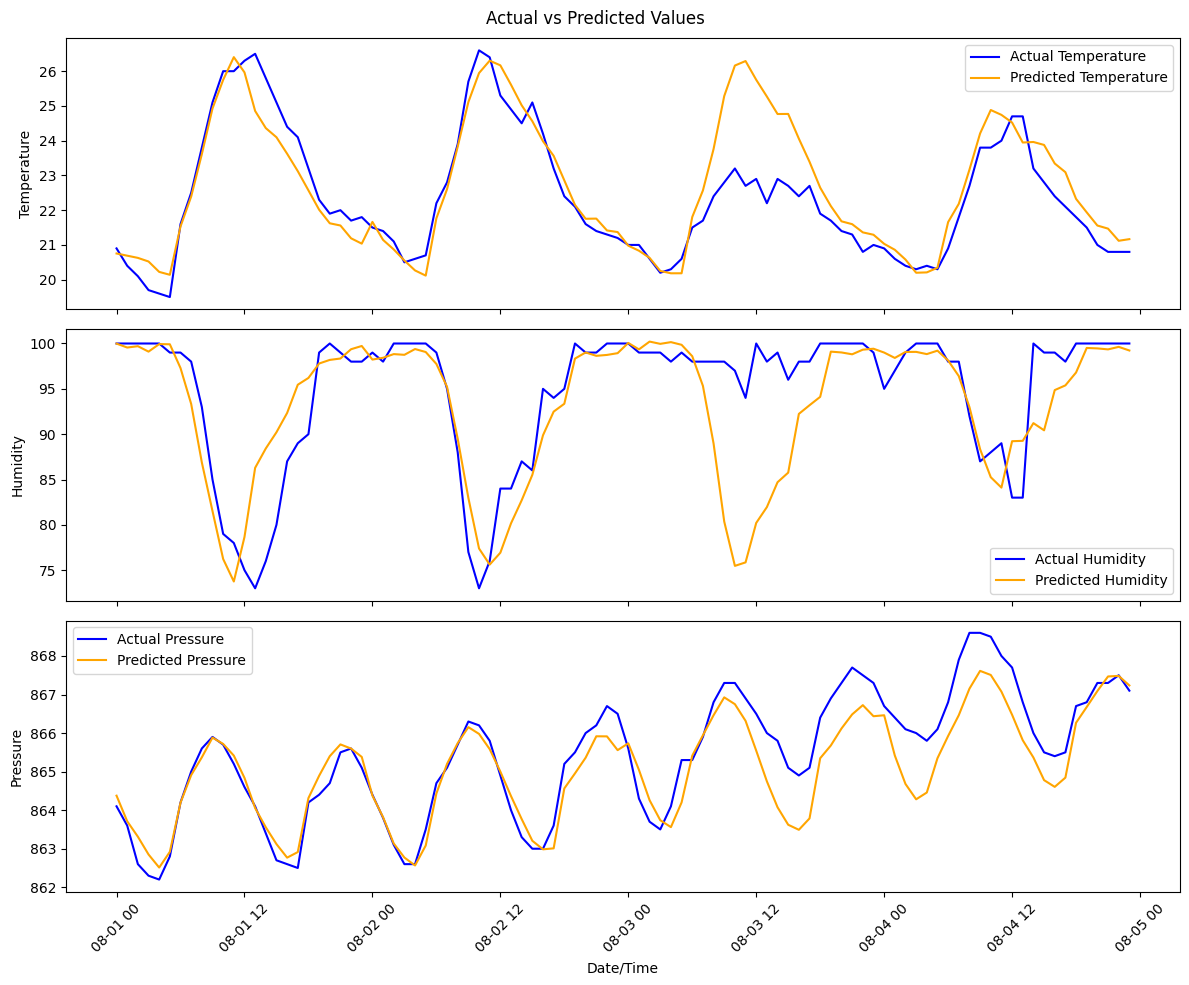

In [ ]:
df_plot = merged_data.copy()
df_plot["ds"] = pd.to_datetime(df_plot["ds"])

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Temperature
axes[0].plot(df_plot["ds"], df_plot["y_temperature"], label="Actual Temperature", color="blue")
axes[0].plot(df_plot["ds"], df_plot["predicted_temperature"], label="Predicted Temperature", color="orange")
axes[0].set_ylabel("Temperature")
axes[0].legend()

# Humidity
axes[1].plot(df_plot["ds"], df_plot["y_humidity"], label="Actual Humidity", color="blue")
axes[1].plot(df_plot["ds"], df_plot["predicted_humidity"], label="Predicted Humidity", color="orange")
axes[1].set_ylabel("Humidity")
axes[1].legend()

# Atmospheric Pressure
axes[2].plot(df_plot["ds"], df_plot["y_atmospheric_pressure"], label="Actual Pressure", color="blue")
axes[2].plot(df_plot["ds"], df_plot["predicted_atmospheric_pressure"], label="Predicted Pressure", color="orange")
axes[2].set_ylabel("Pressure")
axes[2].set_xlabel("Date/Time")
axes[2].legend()

plt.suptitle("Actual vs Predicted Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Evaluation metrics

In [ ]:
cv_prob_df.head()

unique_id                  ds              cutoff      y  \
0  atmospheric_pressure 2025-08-01 00:00:00 2025-07-31 23:00:00  864.1   
1  atmospheric_pressure 2025-08-01 01:00:00 2025-07-31 23:00:00  863.6   
2  atmospheric_pressure 2025-08-01 02:00:00 2025-07-31 23:00:00  862.6   
3  atmospheric_pressure 2025-08-01 03:00:00 2025-07-31 23:00:00  862.3   
4  atmospheric_pressure 2025-08-01 04:00:00 2025-07-31 23:00:00  862.2   

       SARIMA  SARIMA-lo-80  SARIMA-hi-80  
0  864.375905    863.756926    864.994884  
1  863.712292    862.782268    864.642316  
2  863.312335    862.194439    864.430231  
3  862.850890    861.603120    864.098660  
4  862.511401    861.168914    863.853889

In [ ]:
temp_test = small_df.groupby("unique_id").tail(7*8)
temp_train = small_df.drop(temp_test.index).reset_index(drop=True)

In [ ]:
final_cv_df = cv_prob_df.copy()

models = ["SARIMA"]
metrics = [
    mae,
    mse,
    rmse,
    mape,
    smape,
    partial(mase, seasonality=7),
    scaled_crps
]
final_eval_sarima = evaluate(
    final_cv_df.drop(["ds", "cutoff"], axis=1),
    metrics=metrics,
    models=models,
    train_df=temp_train,
    level=[80]
)
final_eval_sarima = final_eval_sarima.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
final_eval_sarima

metric     SARIMA
0          mae   1.629289
1         mape   0.023057
2         mase   0.298734
3          mse  12.369897
4         rmse   2.542426
5  scaled_crps   0.013707
6        smape   0.011606

In [ ]:
sn_prob_df.head()

unique_id                  ds              cutoff      y  \
0  atmospheric_pressure 2025-08-03 00:00:00 2025-08-02 23:00:00  865.6   
1  atmospheric_pressure 2025-08-03 01:00:00 2025-08-02 23:00:00  864.3   
2  atmospheric_pressure 2025-08-03 02:00:00 2025-08-02 23:00:00  863.7   
3  atmospheric_pressure 2025-08-03 03:00:00 2025-08-02 23:00:00  863.5   
4  atmospheric_pressure 2025-08-03 04:00:00 2025-08-02 23:00:00  864.1   

   SeasonalNaive  SeasonalNaive-lo-80  SeasonalNaive-hi-80  
0          864.4           863.289615           865.510385  
1          863.8           862.689615           864.910385  
2          863.1           861.989615           864.210385  
3          862.6           861.489615           863.710385  
4          862.6           861.489615           863.710385

In [ ]:
final_cv_df = sn_prob_df.copy()

model = ["SeasonalNaive"]
final_eval_sn = evaluate(
    final_cv_df.drop(["ds"], axis=1),
    metrics=metrics,
    models=model,
    train_df=temp_train,
    level=[80]
)
final_eval_sn = final_eval_sn.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
final_eval_sn

metric  SeasonalNaive
0          mae       2.265972
1         mape       0.029949
2         mase       0.473004
3          mse      22.187569
4         rmse       3.515621
5  scaled_crps       0.019291
6        smape       0.015070

        metric     SARIMA  SeasonalNaive  abs_improvement  pct_improvement
0          mae   1.629289       2.265972         0.636683        28.097584
1         mape   0.023057       0.029949         0.006892        23.012889
2         mase   0.298734       0.473004         0.174270        36.843325
3          mse  12.369897      22.187569         9.817673        44.248527
4         rmse   2.542426       3.515621         0.973196        27.682042
5  scaled_crps   0.013707       0.019291         0.005584        28.947460
6        smape   0.011606       0.015070         0.003465        22.990224


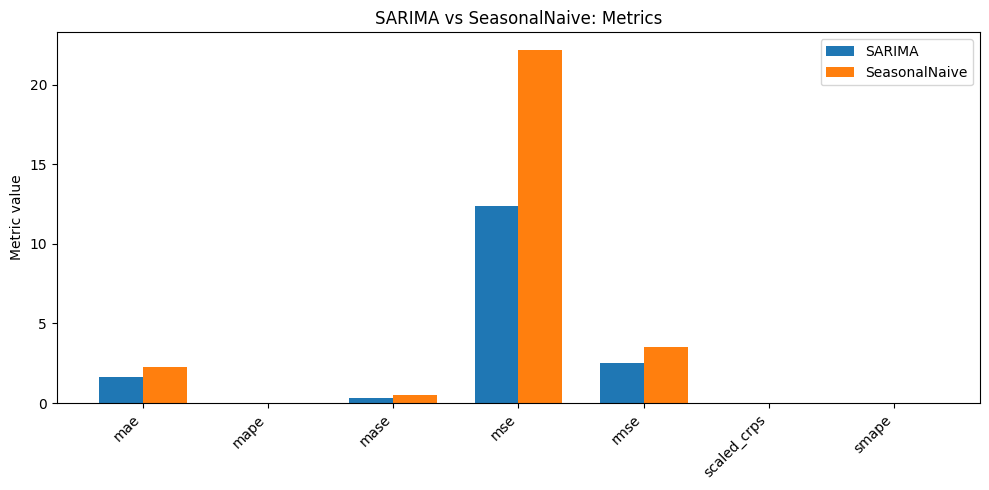

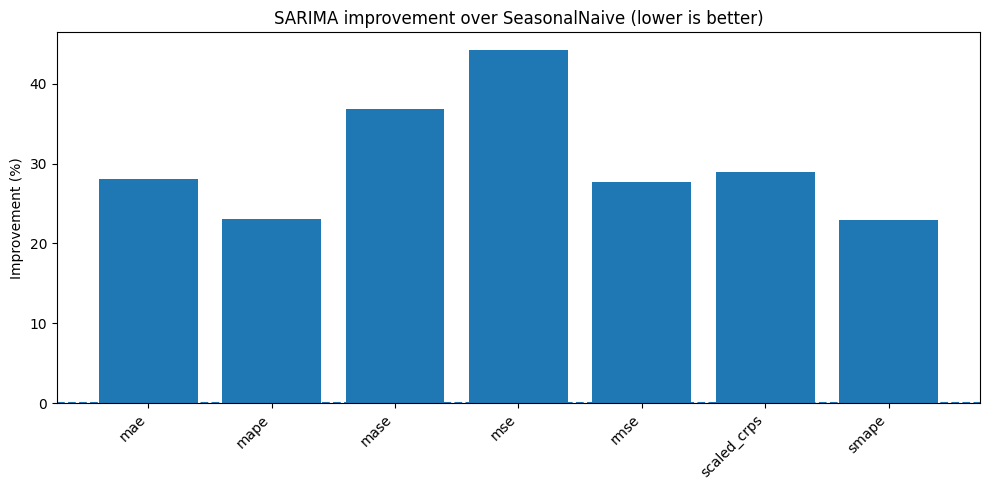

In [ ]:

# 1) Merge to wide table: metric | SARIMA | SeasonalNaive
cmp = (
    final_eval_sarima.rename(columns={"value": "SARIMA"})
    .merge(final_eval_sn.rename(columns={"value": "SeasonalNaive"}), on="metric", how="outer")
)

# 2) Compute improvements (lower is better for these metrics)
cmp["abs_improvement"] = cmp["SeasonalNaive"] - cmp["SARIMA"]
cmp["pct_improvement"] = 100 * cmp["abs_improvement"] / cmp["SeasonalNaive"]

# (optional) order metrics
order = ["mae", "mape", "mase", "mse", "rmse", "scaled_crps", "smape"]
cmp["metric"] = pd.Categorical(cmp["metric"], categories=order, ordered=True)
cmp = cmp.sort_values("metric").reset_index(drop=True)

print(cmp.round(6))

# 3) Plot A: grouped bars of raw metric values
metrics = cmp["metric"].astype(str).tolist()
x = np.arange(len(metrics))
w = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - w/2, cmp["SARIMA"].values, w, label="SARIMA")
plt.bar(x + w/2, cmp["SeasonalNaive"].values, w, label="SeasonalNaive")
plt.xticks(x, metrics, rotation=45, ha="right")
plt.ylabel("Metric value")
plt.title("SARIMA vs SeasonalNaive: Metrics")
plt.legend()
plt.tight_layout()
plt.show()

# 4) Plot B: percent improvement of SARIMA over SeasonalNaive
plt.figure(figsize=(10, 5))
plt.bar(metrics, cmp["pct_improvement"].values)
plt.axhline(0, linestyle="--")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Improvement (%)")  # positive => SARIMA better
plt.title("SARIMA improvement over SeasonalNaive (lower is better)")
plt.tight_layout()
plt.show()

# Tip: if MSE/RMSE dominate Plot A, add this before tight_layout():
# plt.yscale("log")

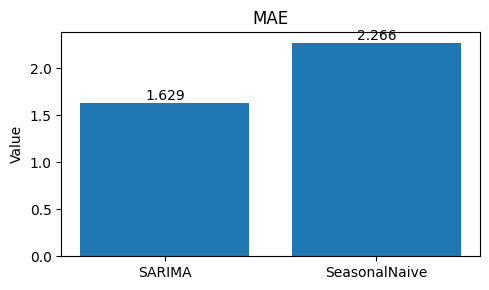

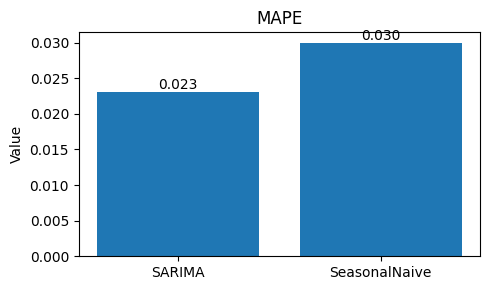

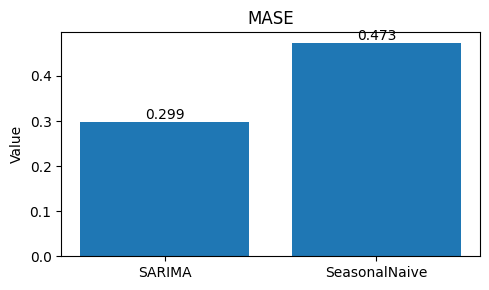

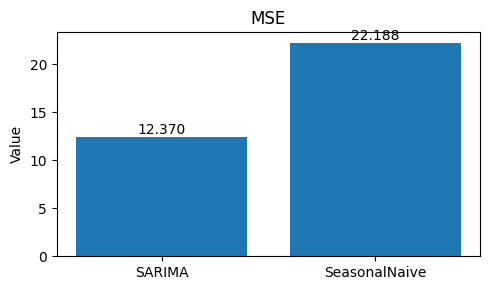

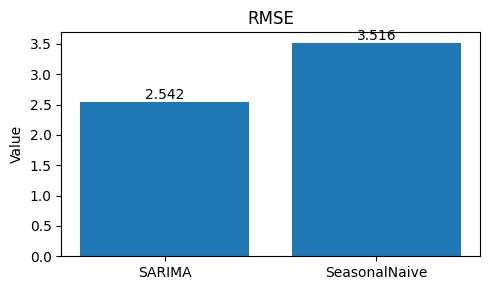

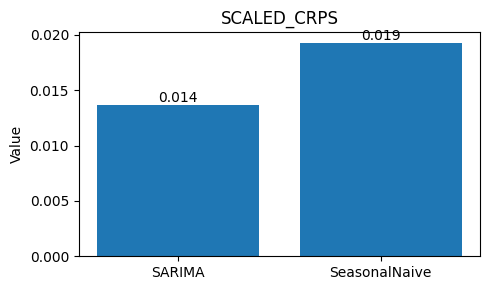

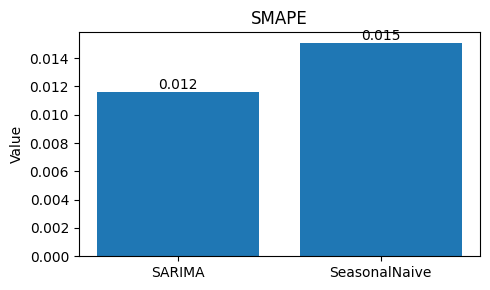

In [ ]:
def tidy_eval(df: pd.DataFrame, model_name: str) -> pd.DataFrame:
    d = df.copy()
    if "value" in d.columns:
        d = d[["metric", "value"]]
    else:
        if model_name in d.columns:
            d = d[["metric", model_name]].rename(columns={model_name: "value"})
        else:
            raise ValueError("Provide a df with a 'value' column or a column named after the model.")
    return d.groupby("metric", as_index=False)["value"].mean().assign(model=model_name)

a = tidy_eval(final_eval_sarima, "SARIMA")
b = tidy_eval(final_eval_sn, "SeasonalNaive")
cmp_long = pd.concat([a, b], ignore_index=True)

wide = cmp_long.pivot(index="metric", columns="model", values="value").reset_index()

order = ["mae", "mape", "mase", "mse", "rmse", "scaled_crps", "smape"]
wide["metric"] = pd.Categorical(wide["metric"], categories=order, ordered=True)
wide = wide.sort_values("metric").reset_index(drop=True)

for _, row in wide.iterrows():
    metric = str(row["metric"])
    vals = [row.get("SARIMA", np.nan), row.get("SeasonalNaive", np.nan)]

    plt.figure(figsize=(5, 3))
    plt.bar(["SARIMA", "SeasonalNaive"], vals)
    for i, v in enumerate(vals):
        if pd.notna(v):
            plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")

    plt.title(metric.upper())
    plt.ylabel("Value")
    plt.tight_layout()


In [ ]:
df_long

ds             unique_id      y
0     2024-01-01 00:00:00  atmospheric_pressure  868.0
1     2024-01-01 00:00:00              humidity   93.0
2     2024-01-01 00:00:00           temperature    7.2
3     2024-01-01 01:00:00  atmospheric_pressure  867.8
4     2024-01-01 01:00:00              humidity   92.0
...                   ...                   ...    ...
41899 2025-08-04 22:00:00              humidity  100.0
41900 2025-08-04 22:00:00           temperature   20.8
41901 2025-08-04 23:00:00  atmospheric_pressure  867.1
41902 2025-08-04 23:00:00              humidity  100.0
41903 2025-08-04 23:00:00           temperature   20.8

[41904 rows x 3 columns]

In [ ]:
df_temp = df_long[df_long["unique_id"] == "temperature"][["ds", "y"]]
df_pressure = df_long[df_long["unique_id"] == "atmospheric_pressure"][["ds", "y"]]
df_humidity = df_long[df_long["unique_id"] == "humidity"][["ds", "y"]]

In [ ]:
df_temp_test = df_temp.tail(24*7)
df_temp_train = df_temp.drop(df_temp_test.index).reset_index(drop=True)

df_pressure_test = df_pressure.tail(24*7)
df_pressure_train = df_pressure.drop(df_pressure_test.index).reset_index(drop=True)

df_humidity_test = df_humidity.tail(24*7)
df_humidity_train = df_humidity.drop(df_humidity_test.index).reset_index(drop=True)


In [ ]:
model_prophet_temp = Prophet()
model_prophet_temp.fit(df_temp_train)

22:04:06 - cmdstanpy - INFO - Chain [1] start processing
22:04:10 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
model_prophet_pressure = Prophet()
model_prophet_pressure.fit(df_pressure_train)

model_prophet_humidity = Prophet()
model_prophet_humidity.fit(df_humidity_train)


22:04:12 - cmdstanpy - INFO - Chain [1] start processing
22:04:15 - cmdstanpy - INFO - Chain [1] done processing
22:04:16 - cmdstanpy - INFO - Chain [1] start processing
22:04:20 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
df_future_temp = model_prophet_temp.make_future_dataframe(periods=24*7, freq='h')
df_future_pressure = model_prophet_pressure.make_future_dataframe(periods=24*7, freq='h')
df_future_humidity = model_prophet_humidity.make_future_dataframe(periods=24*7, freq='h')

display(df_future_temp)
display(df_future_pressure)
display(df_future_humidity)

ds
0     2024-01-01 00:00:00
1     2024-01-01 01:00:00
2     2024-01-01 02:00:00
3     2024-01-01 03:00:00
4     2024-01-01 04:00:00
...                   ...
13963 2025-08-04 19:00:00
13964 2025-08-04 20:00:00
13965 2025-08-04 21:00:00
13966 2025-08-04 22:00:00
13967 2025-08-04 23:00:00

[13968 rows x 1 columns]

ds
0     2024-01-01 00:00:00
1     2024-01-01 01:00:00
2     2024-01-01 02:00:00
3     2024-01-01 03:00:00
4     2024-01-01 04:00:00
...                   ...
13963 2025-08-04 19:00:00
13964 2025-08-04 20:00:00
13965 2025-08-04 21:00:00
13966 2025-08-04 22:00:00
13967 2025-08-04 23:00:00

[13968 rows x 1 columns]

ds
0     2024-01-01 00:00:00
1     2024-01-01 01:00:00
2     2024-01-01 02:00:00
3     2024-01-01 03:00:00
4     2024-01-01 04:00:00
...                   ...
13963 2025-08-04 19:00:00
13964 2025-08-04 20:00:00
13965 2025-08-04 21:00:00
13966 2025-08-04 22:00:00
13967 2025-08-04 23:00:00

[13968 rows x 1 columns]

In [ ]:
forecast_prophet_temp = model_prophet_temp.predict(df_future_temp)
forecast_prophet_temp[['ds','yhat', 'yhat_lower', 'yhat_upper']].round().tail()

forecast_prophet_pressure = model_prophet_pressure.predict(df_future_pressure)
forecast_prophet_pressure[['ds','yhat', 'yhat_lower', 'yhat_upper']].round().tail()

forecast_prophet_humidity = model_prophet_humidity.predict(df_future_humidity)
forecast_prophet_humidity[['ds','yhat', 'yhat_lower', 'yhat_upper']].round().tail()

ds   yhat  yhat_lower  yhat_upper
13963 2025-08-04 19:00:00  106.0        91.0       122.0
13964 2025-08-04 20:00:00  108.0        93.0       123.0
13965 2025-08-04 21:00:00  109.0        94.0       124.0
13966 2025-08-04 22:00:00  109.0        95.0       124.0
13967 2025-08-04 23:00:00  110.0        96.0       126.0

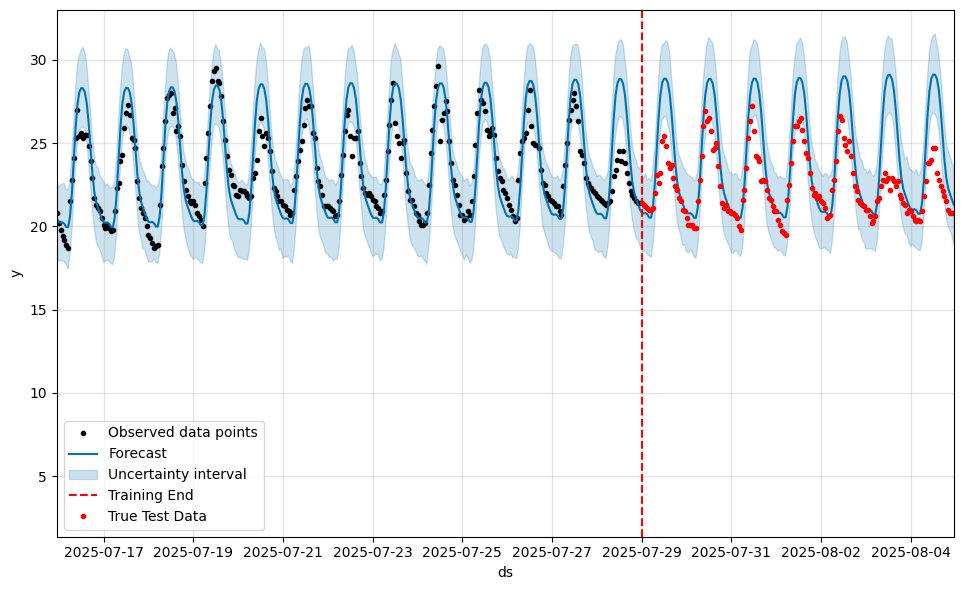

In [ ]:
fig1 = model_prophet_temp.plot(forecast_prophet_temp)

end_date = forecast_prophet_temp['ds'].max()
start_date = end_date - pd.DateOffset(days=20)

axes = fig1.gca()
axes.set_xlim([start_date, end_date])

last_training_date = forecast_prophet_temp['ds'].iloc[-24*7]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

plt.plot(df_temp_test['ds'], df_temp_test['y'],'ro', markersize=3, label='True Test Data')

plt.legend()

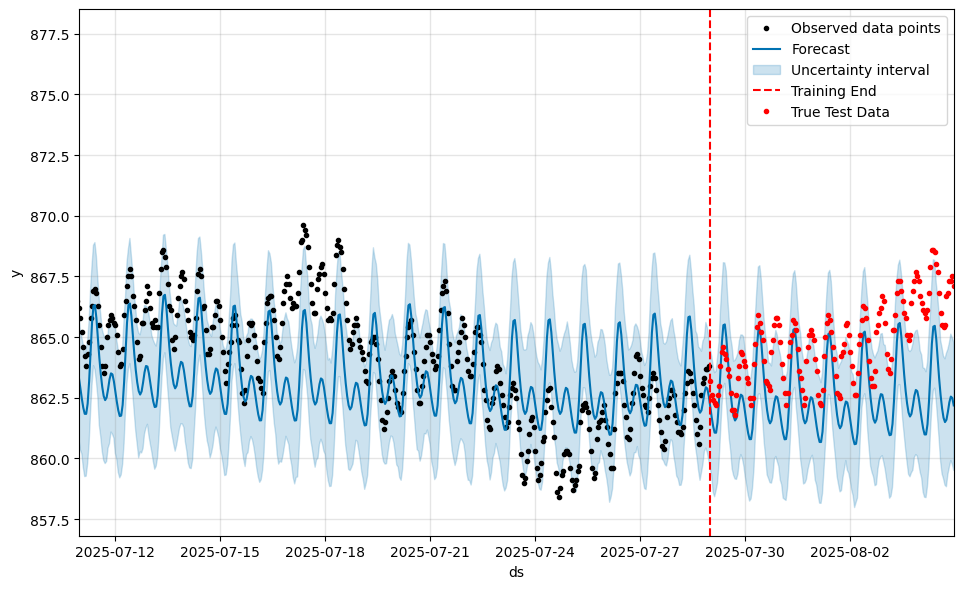

In [ ]:
fig2 = model_prophet_pressure.plot(forecast_prophet_pressure)

end_date = forecast_prophet_pressure['ds'].max()
start_date = end_date - pd.DateOffset(days=25)

axes = fig2.gca()
axes.set_xlim([start_date, end_date])

last_training_date = forecast_prophet_pressure['ds'].iloc[-24*7]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

plt.plot(df_pressure_test['ds'], df_pressure_test['y'],'ro', markersize=3, label='True Test Data')

plt.legend()

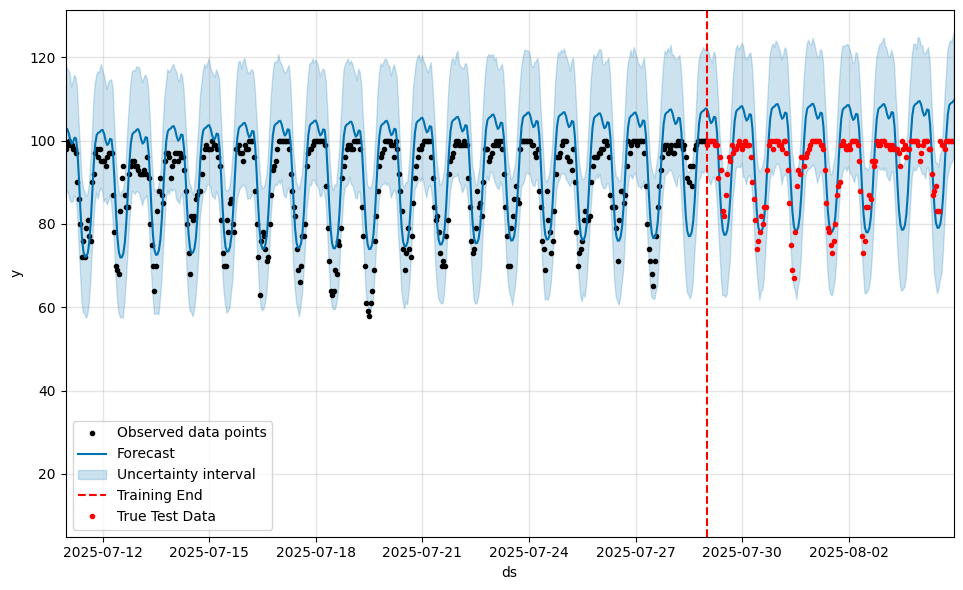

In [ ]:
fig3 = model_prophet_humidity.plot(forecast_prophet_humidity)

end_date = forecast_prophet_humidity['ds'].max()
start_date = end_date - pd.DateOffset(days=25)

axes = fig3.gca()
axes.set_xlim([start_date, end_date])

last_training_date = forecast_prophet_humidity['ds'].iloc[-24*7]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

plt.plot(df_humidity_test['ds'], df_humidity_test['y'],'ro', markersize=3, label='True Test Data')

plt.legend()


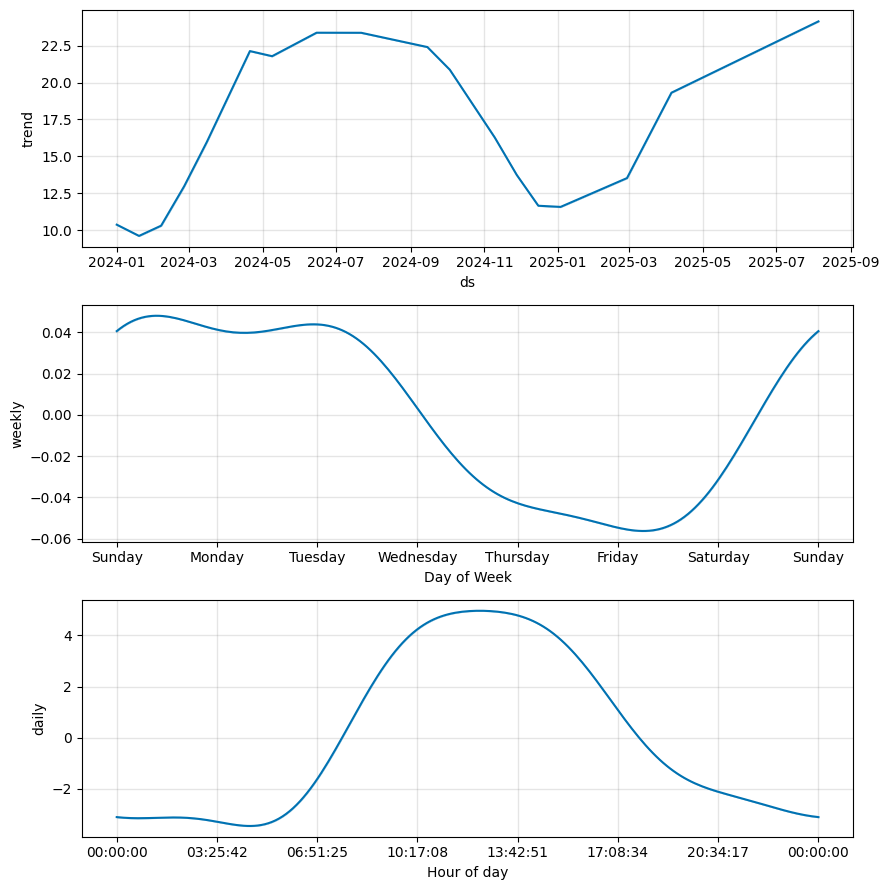

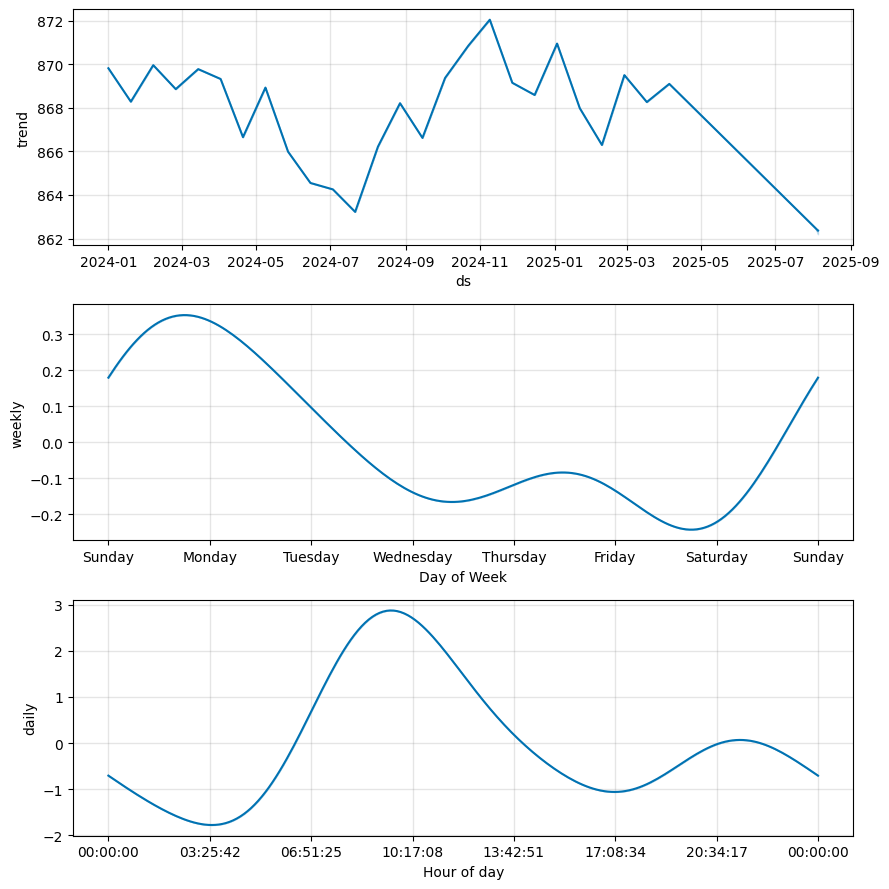

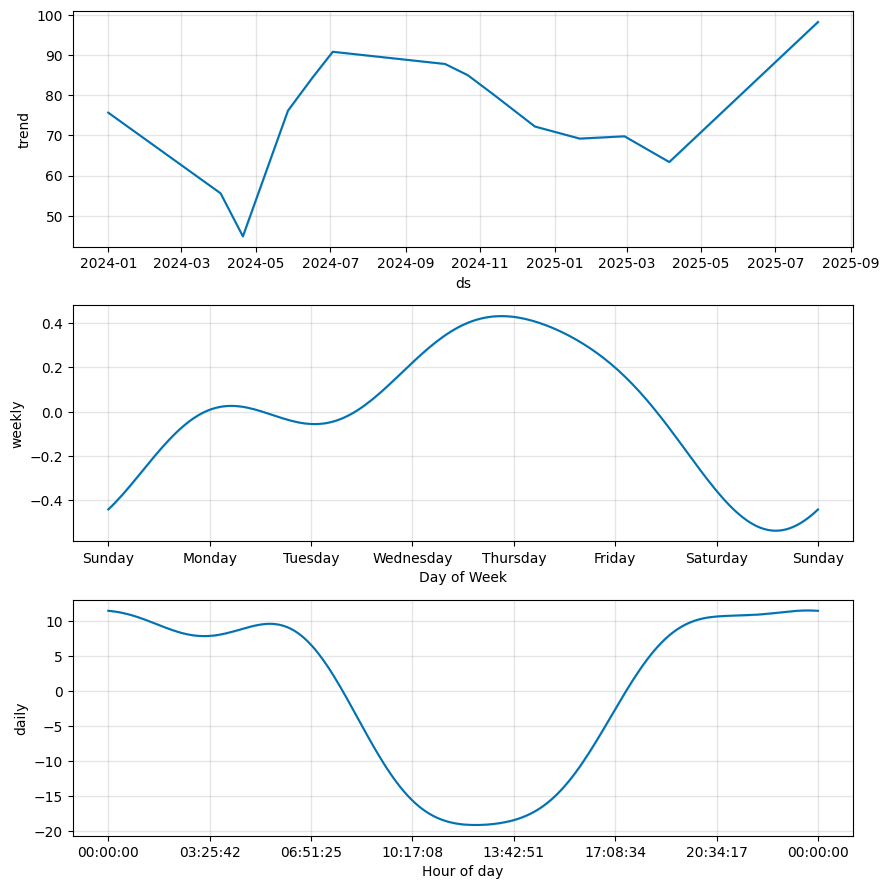

In [ ]:
fig4 = model_prophet_temp.plot_components(forecast_prophet_temp)
fig5 = model_prophet_pressure.plot_components(forecast_prophet_pressure)
fig6 = model_prophet_humidity.plot_components(forecast_prophet_humidity)


In [ ]:
forecast_prophet_temp.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2024-01-01 00:00:00  10.373454    5.250380    9.609105    10.373454   
1 2024-01-01 01:00:00  10.371721    5.061680    9.701330    10.371721   
2 2024-01-01 02:00:00  10.369989    4.852024    9.678065    10.369989   
3 2024-01-01 03:00:00  10.368256    4.843639    9.363298    10.368256   
4 2024-01-01 04:00:00  10.366523    4.581278    9.371749    10.366523   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    10.373454       -3.061685             -3.061685             -3.061685   
1    10.371721       -3.101592             -3.101592             -3.101592   
2    10.369989       -3.076323             -3.076323             -3.076323   
3    10.368256       -3.162062             -3.162062             -3.162062   
4    10.366523       -3.356445             -3.356445             -3.356445   

      daily  daily_lower  daily_upper    weekly  weekly_lower  weekly_upper  \
0 -3.103024    -3.103024    -3.103024  0.041339      0.041339      0.041339   
1 -3.142502    -3.142502    -3.142502  0.040910      0.040910      0.040910   
2 -3.116865    -3.116865    -3.116865  0.040543      0.040543      0.040543   
3 -3.202306    -3.202306    -3.202306  0.040243      0.040243      0.040243   
4 -3.396460    -3.396460    -3.396460  0.040016      0.040016      0.040016   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper      yhat  
0                         0.0  7.311769  
1                         0.0  7.270129  
2                         0.0  7.293666  
3                         0.0  7.206194  
4                         0.0  7.010079

In [ ]:
p_eval_temp_df = pd.merge(df_temp_test, forecast_prophet_temp, 'left', ['ds'])
p_eval_temp_df = p_eval_temp_df[['ds', 'y', 'yhat']].copy()
p_eval_temp_df['unique_id'] = 'temp'

p_eval_pressure_df = pd.merge(df_pressure_test, forecast_prophet_pressure, 'left', ['ds'])
p_eval_pressure_df = p_eval_pressure_df[['ds', 'y', 'yhat']].copy()
p_eval_pressure_df['unique_id'] = 'pressure'

p_eval_humidity_df = pd.merge(df_humidity_test, forecast_prophet_humidity, 'left', ['ds'])
p_eval_humidity_df = p_eval_humidity_df[['ds', 'y', 'yhat']].copy()
p_eval_humidity_df['unique_id'] = 'humidity'

p_eval_df = pd.concat([p_eval_temp_df, p_eval_pressure_df, p_eval_humidity_df], axis=0)


In [ ]:
p_eval_df

ds      y        yhat unique_id
0   2025-07-29 00:00:00   21.4   20.809745      temp
1   2025-07-29 01:00:00   21.3   20.771766      temp
2   2025-07-29 02:00:00   21.2   20.798782      temp
3   2025-07-29 03:00:00   21.1   20.714592      temp
4   2025-07-29 04:00:00   21.0   20.521551      temp
..                  ...    ...         ...       ...
163 2025-08-04 19:00:00  100.0  106.275703  humidity
164 2025-08-04 20:00:00  100.0  108.487680  humidity
165 2025-08-04 21:00:00  100.0  108.982274  humidity
166 2025-08-04 22:00:00  100.0  109.173187  humidity
167 2025-08-04 23:00:00  100.0  109.609531  humidity

[504 rows x 4 columns]

In [ ]:
p_eval = evaluate(
    p_eval_df,
    metrics=[mae],
)
p_eval

unique_id metric      yhat
0  humidity    mae  7.572805
1  pressure    mae  2.221570
2      temp    mae  1.631902

In [ ]:
p_eval_mean = p_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
p_eval_mean

metric      yhat
0    mae  3.808759